# Work From Home Analysis & Interactive Patterns

**Did COVID permanently change commute patterns?**

This notebook explores:
1. Monday/Friday ridership changes (WFH indicator)
2. Controlling for weather and system growth
3. Interactive heatmaps with toggles for different segments
4. **Day-by-day weather + ridership explorer**

---
## 🎯 Focus: Members only (commuters), controlling for weather

In [98]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

con = duckdb.connect()
print('Connected to DuckDB')

Connected to DuckDB


---
## 1. The WFH Hypothesis

**Hypothesis**: After COVID, more people work from home on Mondays and Fridays, leading to lower commute ridership on those days compared to Tue/Wed/Thu.

Let's test this by comparing day-of-week patterns before and after COVID.

In [99]:
# Get daily data with day of week
daily = con.execute("""
    SELECT 
        DATE(started_at) as date,
        EXTRACT(YEAR FROM started_at) as year,
        EXTRACT(DOW FROM started_at) as dow,
        CASE EXTRACT(DOW FROM started_at)
            WHEN 0 THEN 'Sunday'
            WHEN 1 THEN 'Monday'
            WHEN 2 THEN 'Tuesday'
            WHEN 3 THEN 'Wednesday'
            WHEN 4 THEN 'Thursday'
            WHEN 5 THEN 'Friday'
            WHEN 6 THEN 'Saturday'
        END as day_name,
        COUNT(*) as trips,
        COUNT(*) FILTER (WHERE member_casual = 'member') as member_trips,
        COUNT(DISTINCT start_station_id) as active_stations
    FROM '../data/processed/*.parquet'
    GROUP BY 1, 2, 3, 4
    ORDER BY 1
""").fetchdf()

daily['date'] = pd.to_datetime(daily['date'])
daily['member_pct'] = daily['member_trips'] / daily['trips'] * 100

# Define periods
daily['period'] = 'Pre-COVID'
daily.loc[daily['year'] == 2020, 'period'] = 'COVID-2020'
daily.loc[daily['year'] == 2021, 'period'] = 'Recovery-2021'
daily.loc[daily['year'] >= 2022, 'period'] = 'Post-COVID'

print(f"Daily records: {len(daily):,}")
print(f"\nPeriods:")
print(daily.groupby('period').agg({'date': ['min', 'max'], 'trips': 'sum'}))

Daily records: 4,557

Periods:
                    date                 trips
                     min        max        sum
period                                        
COVID-2020    2020-01-01 2020-12-31   19309183
Post-COVID    2022-01-01 2025-11-30  150212164
Pre-COVID     2013-06-01 2019-12-31   91316334
Recovery-2021 2021-01-01 2021-12-31   26724796


In [100]:
# Calculate day-of-week patterns by period (weekdays only)
weekday_only = daily[daily['dow'].isin([1, 2, 3, 4, 5])].copy()

# Normalize: calculate each day's trips as % of that week's average
# This controls for overall growth
weekday_only['week'] = weekday_only['date'].dt.isocalendar().week
weekday_only['year_week'] = weekday_only['year'].astype(str) + '-' + weekday_only['week'].astype(str)

weekly_avg = weekday_only.groupby('year_week')['trips'].mean().reset_index()
weekly_avg.columns = ['year_week', 'week_avg']
weekday_only = weekday_only.merge(weekly_avg, on='year_week')
weekday_only['pct_of_week_avg'] = weekday_only['trips'] / weekday_only['week_avg'] * 100

# Summarize by period and day
dow_by_period = weekday_only.groupby(['period', 'day_name']).agg({
    'pct_of_week_avg': 'mean',
    'trips': 'mean'
}).reset_index()

# Order days correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
dow_by_period['day_name'] = pd.Categorical(dow_by_period['day_name'], categories=day_order, ordered=True)
dow_by_period = dow_by_period.sort_values(['period', 'day_name'])

print("Day-of-Week Pattern (% of week average):")
pivot = dow_by_period.pivot(index='day_name', columns='period', values='pct_of_week_avg')
pivot = pivot[['Pre-COVID', 'COVID-2020', 'Recovery-2021', 'Post-COVID']]
print(pivot.round(1))

Day-of-Week Pattern (% of week average):
period     Pre-COVID  COVID-2020  Recovery-2021  Post-COVID
day_name                                                   
Monday          95.5        93.8           90.7        92.0
Tuesday        100.6       106.9          102.2       100.7
Wednesday      104.2       103.9          104.0       103.7
Thursday       101.4        98.1          100.3       102.2
Friday          98.3        97.3          102.7       101.4


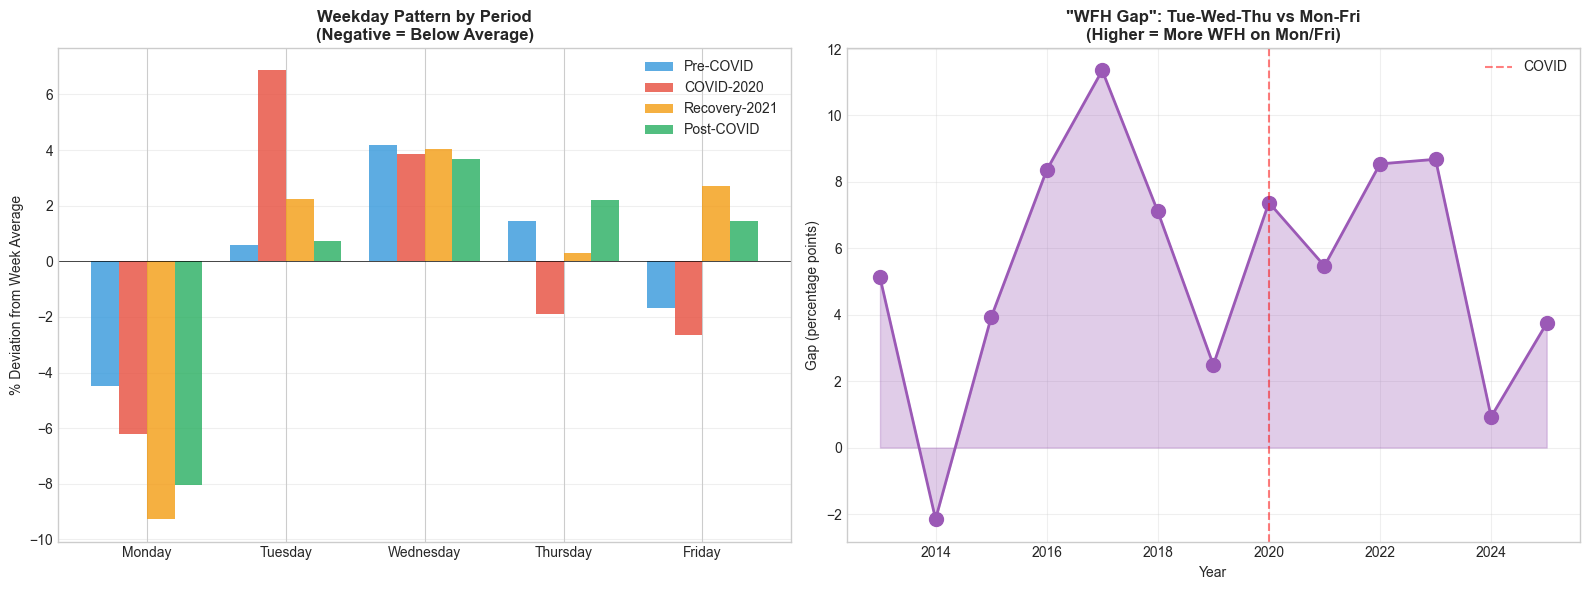


WFH Gap by Year:
day_name  Mon_Fri_avg  Tue_Wed_Thu_avg  WFH_gap
year                                           
2013             96.9            102.1      5.1
2014            101.3             99.2     -2.2
2015             97.6            101.6      3.9
2016             95.0            103.3      8.4
2017             93.3            104.6     11.4
2018             95.8            102.9      7.1
2019             98.5            101.0      2.5
2020             95.6            102.9      7.4
2021             96.7            102.2      5.5
2022             94.9            103.4      8.5
2023             94.8            103.5      8.7
2024             99.5            100.4      0.9
2025             97.7            101.5      3.7


In [101]:
# Visualize the WFH effect
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Day of week pattern by period
ax = axes[0]
colors = {'Pre-COVID': '#3498db', 'COVID-2020': '#e74c3c', 'Recovery-2021': '#f39c12', 'Post-COVID': '#27ae60'}
x = np.arange(5)
width = 0.2

for i, (period, color) in enumerate(colors.items()):
    data = pivot[period].values
    ax.bar(x + i*width, data - 100, width, label=period, color=color, alpha=0.8)

ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(x + 1.5*width)
ax.set_xticklabels(day_order)
ax.set_ylabel('% Deviation from Week Average')
ax.set_title('Weekday Pattern by Period\n(Negative = Below Average)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 2. Monday/Friday gap over time
ax = axes[1]

# Calculate Mon+Fri average vs Tue+Wed+Thu average per year
yearly_dow = weekday_only.groupby(['year', 'day_name'])['pct_of_week_avg'].mean().reset_index()
yearly_pivot = yearly_dow.pivot(index='year', columns='day_name', values='pct_of_week_avg')

yearly_pivot['Mon_Fri_avg'] = (yearly_pivot['Monday'] + yearly_pivot['Friday']) / 2
yearly_pivot['Tue_Wed_Thu_avg'] = (yearly_pivot['Tuesday'] + yearly_pivot['Wednesday'] + yearly_pivot['Thursday']) / 3
yearly_pivot['WFH_gap'] = yearly_pivot['Tue_Wed_Thu_avg'] - yearly_pivot['Mon_Fri_avg']

ax.plot(yearly_pivot.index, yearly_pivot['WFH_gap'], 'o-', linewidth=2, markersize=10, color='#9b59b6')
ax.axvline(2020, color='red', linestyle='--', alpha=0.5, label='COVID')
ax.fill_between(yearly_pivot.index, 0, yearly_pivot['WFH_gap'], alpha=0.3, color='#9b59b6')

ax.set_xlabel('Year')
ax.set_ylabel('Gap (percentage points)')
ax.set_title('"WFH Gap": Tue-Wed-Thu vs Mon-Fri\n(Higher = More WFH on Mon/Fri)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../logs/wfh_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nWFH Gap by Year:")
print(yearly_pivot[['Mon_Fri_avg', 'Tue_Wed_Thu_avg', 'WFH_gap']].round(1))

---
## 2. Weather-Controlled WFH Analysis

Let's use regression to control for weather, holidays, and system size.

In [102]:
# Get daily data with weather
daily_weather = con.execute("""
    SELECT 
        DATE(t.started_at) as date,
        EXTRACT(YEAR FROM t.started_at) as year,
        EXTRACT(DOW FROM t.started_at) as dow,
        COUNT(*) as trips,
        COUNT(*) FILTER (WHERE t.member_casual = 'member') as member_trips,
        COUNT(DISTINCT t.start_station_id) as active_stations,
        AVG(w.temperature_2m) * 9/5 + 32 as temp_f,
        MAX(w.precipitation) as precip_mm,
        MAX(CASE WHEN h.holiday_name IS NOT NULL THEN 1 ELSE 0 END) as is_holiday
    FROM '../data/processed/*.parquet' t
    LEFT JOIN '../data/weather/hourly_weather.parquet' w
        ON DATE_TRUNC('hour', t.started_at) = w.datetime
    LEFT JOIN '../data/weather/holidays.parquet' h
        ON DATE(t.started_at) = h.date
    GROUP BY 1, 2, 3
    ORDER BY 1
""").fetchdf()

daily_weather['date'] = pd.to_datetime(daily_weather['date'])
daily_weather['is_weekend'] = daily_weather['dow'].isin([0, 6]).astype(int)
daily_weather['is_monday'] = (daily_weather['dow'] == 1).astype(int)
daily_weather['is_friday'] = (daily_weather['dow'] == 5).astype(int)
daily_weather['is_rainy'] = (daily_weather['precip_mm'] > 0).astype(int)

# Period dummies
daily_weather['post_covid'] = (daily_weather['year'] >= 2022).astype(int)
daily_weather['is_2020'] = (daily_weather['year'] == 2020).astype(int)
daily_weather['is_2021'] = (daily_weather['year'] == 2021).astype(int)

# Interaction terms: Monday/Friday effect AFTER COVID
daily_weather['monday_post_covid'] = daily_weather['is_monday'] * daily_weather['post_covid']
daily_weather['friday_post_covid'] = daily_weather['is_friday'] * daily_weather['post_covid']

print(f"Records: {len(daily_weather):,}")
daily_weather.head()

Records: 4,557


,date,year,dow,trips,member_trips,active_stations,temp_f,precip_mm,is_holiday,is_weekend,is_monday,is_friday,is_rainy,post_covid,is_2020,is_2021,monday_post_covid,friday_post_covid
0,2013-06-01,2013,6,8427,4961,318,82.463054,0.0,0,1,0,0,0,0,0,0,0,0
1,2013-06-02,2013,0,15607,5117,322,81.149596,1.9,0,1,0,0,1,0,0,0,0,0
2,2013-06-03,2013,1,7359,4469,314,72.577269,6.0,0,0,1,0,1,0,0,0,0,0
3,2013-06-04,2013,2,15180,8501,319,67.010794,0.0,0,0,0,0,0,0,0,0,0,0
4,2013-06-05,2013,3,15250,8366,321,65.582547,0.0,0,0,0,0,0,0,0,0,0,0


In [103]:
# Regression model for MEMBER trips only (commuters)
# Filter to weekdays only
weekdays = daily_weather[daily_weather['is_weekend'] == 0].copy()
weekdays = weekdays.dropna()

# Temperature bins
weekdays['temp_cold'] = (weekdays['temp_f'] < 50).astype(int)
weekdays['temp_cool'] = ((weekdays['temp_f'] >= 50) & (weekdays['temp_f'] < 65)).astype(int)
weekdays['temp_hot'] = (weekdays['temp_f'] >= 80).astype(int)

# Year dummies (2019 as reference - last pre-COVID year)
year_dummies = pd.get_dummies(weekdays['year'], prefix='year').astype(int)
year_dummies = year_dummies.drop('year_2019', axis=1, errors='ignore')

# Features
X = pd.concat([
    weekdays[['temp_cold', 'temp_cool', 'temp_hot', 'is_rainy', 'is_holiday', 'active_stations',
              'is_monday', 'is_friday', 'monday_post_covid', 'friday_post_covid']],
    year_dummies
], axis=1)

y = weekdays['member_trips']

# Fit model
model = sm.OLS(y, sm.add_constant(X)).fit()

print("MEMBER TRIPS REGRESSION (Weekdays Only)")
print("="*60)
print(f"R-squared: {model.rsquared:.3f}")
print(f"\nKEY COEFFICIENTS:")
print(f"{'Variable':<25} {'Coef':>12} {'Std Err':>10} {'P-value':>10}")
print("-"*60)

key_vars = ['is_monday', 'is_friday', 'monday_post_covid', 'friday_post_covid']
for var in key_vars:
    coef = model.params[var]
    se = model.bse[var]
    pval = model.pvalues[var]
    sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
    print(f"{var:<25} {coef:>+12,.0f} {se:>10,.0f} {pval:>10.4f} {sig}")

print("\n" + "="*60)
print("INTERPRETATION:")
print(f"  - Monday effect (pre-COVID): {model.params['is_monday']:+,.0f} trips vs Tue-Thu")
print(f"  - Friday effect (pre-COVID): {model.params['is_friday']:+,.0f} trips vs Tue-Thu")
print(f"  - ADDITIONAL Monday drop post-COVID: {model.params['monday_post_covid']:+,.0f} trips")
print(f"  - ADDITIONAL Friday drop post-COVID: {model.params['friday_post_covid']:+,.0f} trips")

MEMBER TRIPS REGRESSION (Weekdays Only)
R-squared: 0.862

KEY COEFFICIENTS:
Variable                          Coef    Std Err    P-value
------------------------------------------------------------
is_monday                       -1,815        700     0.0096 **
is_friday                       -2,289        691     0.0009 ***
monday_post_covid               -6,542      1,236     0.0000 ***
friday_post_covid               -3,067      1,235     0.0130 *

INTERPRETATION:
  - Monday effect (pre-COVID): -1,815 trips vs Tue-Thu
  - Friday effect (pre-COVID): -2,289 trips vs Tue-Thu
  - ADDITIONAL Monday drop post-COVID: -6,542 trips
  - ADDITIONAL Friday drop post-COVID: -3,067 trips


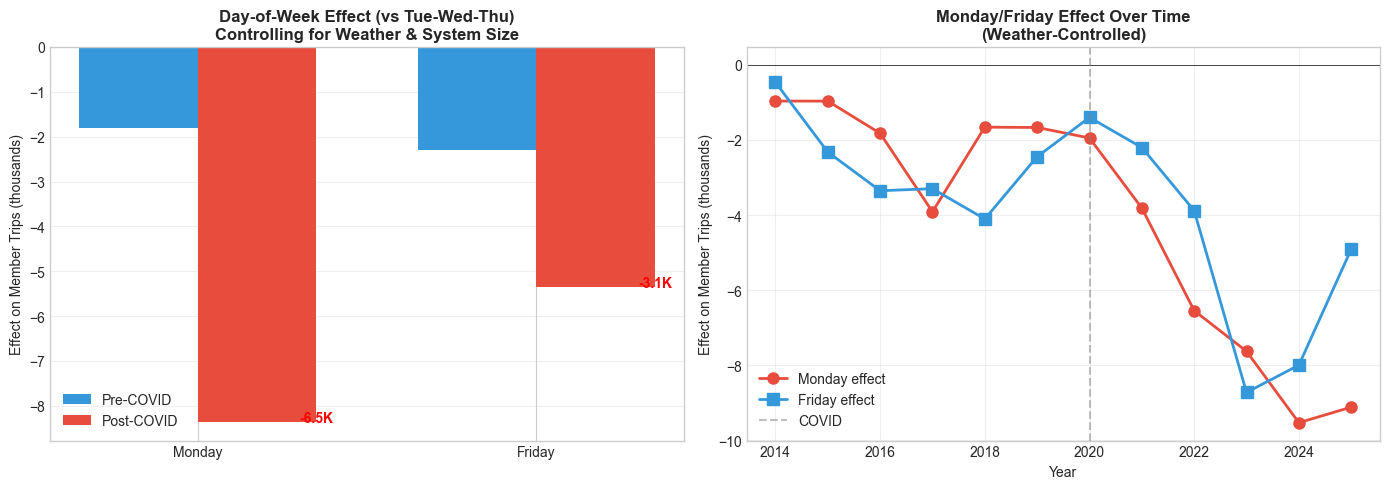

In [104]:
# Visualize the regression results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Monday/Friday effects pre vs post COVID
ax = axes[0]
x = np.arange(2)
width = 0.35

pre_effects = [model.params['is_monday'], model.params['is_friday']]
post_effects = [model.params['is_monday'] + model.params['monday_post_covid'], 
                model.params['is_friday'] + model.params['friday_post_covid']]

ax.bar(x - width/2, [e/1000 for e in pre_effects], width, label='Pre-COVID', color='#3498db')
ax.bar(x + width/2, [e/1000 for e in post_effects], width, label='Post-COVID', color='#e74c3c')

ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(['Monday', 'Friday'])
ax.set_ylabel('Effect on Member Trips (thousands)')
ax.set_title('Day-of-Week Effect (vs Tue-Wed-Thu)\nControlling for Weather & System Size', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add change annotations
for i, (pre, post) in enumerate(zip(pre_effects, post_effects)):
    change = post - pre
    ax.annotate(f'{change/1000:+.1f}K', xy=(i, post/1000), xytext=(i+0.3, post/1000),
                fontsize=10, color='red', fontweight='bold')

# 2. Year-by-year Monday effect
ax = axes[1]

# Run separate regressions by year to get Monday effect
yearly_effects = []
for year in range(2014, 2026):
    year_data = weekdays[weekdays['year'] == year].dropna()
    if len(year_data) < 100:
        continue
    X_year = year_data[['temp_cold', 'temp_cool', 'temp_hot', 'is_rainy', 'is_holiday', 
                        'active_stations', 'is_monday', 'is_friday']]
    y_year = year_data['member_trips']
    try:
        model_year = sm.OLS(y_year, sm.add_constant(X_year)).fit()
        yearly_effects.append({
            'year': year,
            'monday_effect': model_year.params.get('is_monday', 0),
            'friday_effect': model_year.params.get('is_friday', 0)
        })
    except:
        pass

effects_df = pd.DataFrame(yearly_effects)

ax.plot(effects_df['year'], effects_df['monday_effect']/1000, 'o-', linewidth=2, markersize=8, 
        label='Monday effect', color='#e74c3c')
ax.plot(effects_df['year'], effects_df['friday_effect']/1000, 's-', linewidth=2, markersize=8, 
        label='Friday effect', color='#3498db')
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(2020, color='gray', linestyle='--', alpha=0.5, label='COVID')

ax.set_xlabel('Year')
ax.set_ylabel('Effect on Member Trips (thousands)')
ax.set_title('Monday/Friday Effect Over Time\n(Weather-Controlled)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../logs/wfh_regression.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Hourly Pattern Changes (Morning Commute)

Has the morning rush hour shifted or shrunk post-COVID?

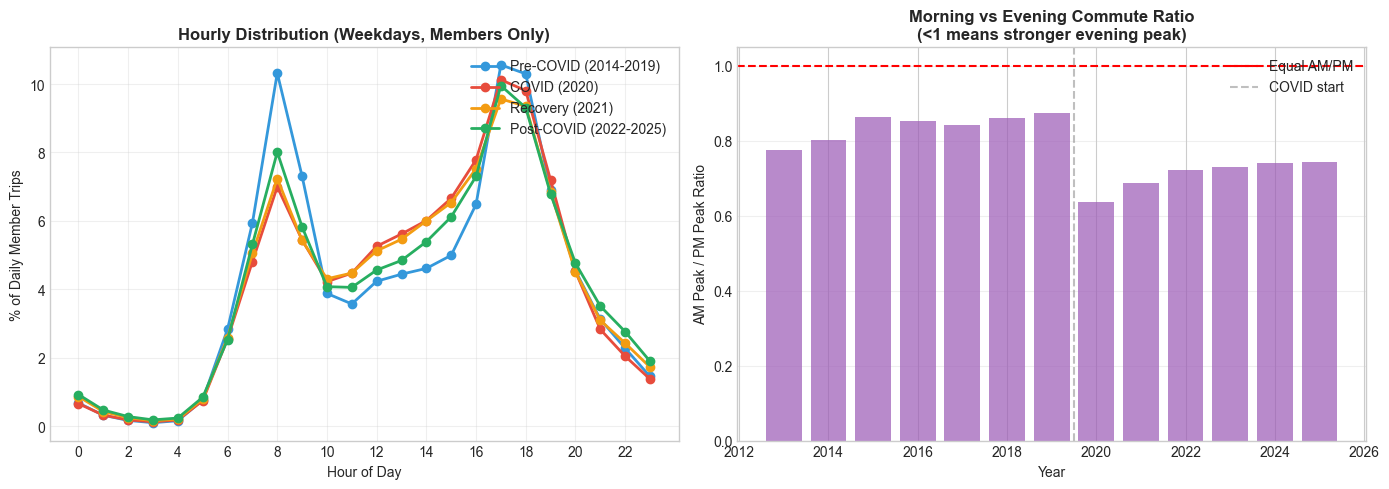

In [105]:
# Get hourly patterns by period
hourly_by_period = con.execute("""
    SELECT 
        CASE 
            WHEN EXTRACT(YEAR FROM started_at) <= 2019 THEN 'Pre-COVID (2014-2019)'
            WHEN EXTRACT(YEAR FROM started_at) = 2020 THEN 'COVID (2020)'
            WHEN EXTRACT(YEAR FROM started_at) = 2021 THEN 'Recovery (2021)'
            ELSE 'Post-COVID (2022-2025)'
        END as period,
        EXTRACT(HOUR FROM started_at) as hour,
        COUNT(*) as trips,
        COUNT(*) FILTER (WHERE member_casual = 'member') as member_trips
    FROM '../data/processed/*.parquet'
    WHERE EXTRACT(DOW FROM started_at) NOT IN (0, 6)  -- Weekdays only
    GROUP BY 1, 2
""").fetchdf()

# Normalize each period to sum to 100%
period_totals = hourly_by_period.groupby('period')['member_trips'].sum()
hourly_by_period = hourly_by_period.merge(
    period_totals.reset_index().rename(columns={'member_trips': 'period_total'}),
    on='period'
)
hourly_by_period['pct_of_day'] = hourly_by_period['member_trips'] / hourly_by_period['period_total'] * 100

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Hourly distribution by period
ax = axes[0]
colors = {'Pre-COVID (2014-2019)': '#3498db', 'COVID (2020)': '#e74c3c', 
          'Recovery (2021)': '#f39c12', 'Post-COVID (2022-2025)': '#27ae60'}

for period, color in colors.items():
    data = hourly_by_period[hourly_by_period['period'] == period].sort_values('hour')
    ax.plot(data['hour'], data['pct_of_day'], 'o-', linewidth=2, label=period, color=color)

ax.set_xlabel('Hour of Day')
ax.set_ylabel('% of Daily Member Trips')
ax.set_title('Hourly Distribution (Weekdays, Members Only)', fontweight='bold')
ax.legend(loc='upper right')
ax.set_xticks(range(0, 24, 2))
ax.grid(True, alpha=0.3)

# 2. Morning vs Evening peak ratio
ax = axes[1]

# Calculate AM peak (7-9) vs PM peak (5-7) ratio by year
peak_ratio = con.execute("""
    SELECT 
        EXTRACT(YEAR FROM started_at) as year,
        COUNT(*) FILTER (WHERE EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9) as am_peak,
        COUNT(*) FILTER (WHERE EXTRACT(HOUR FROM started_at) BETWEEN 17 AND 19) as pm_peak
    FROM '../data/processed/*.parquet'
    WHERE EXTRACT(DOW FROM started_at) NOT IN (0, 6)
      AND member_casual = 'member'
    GROUP BY 1
    ORDER BY 1
""").fetchdf()

peak_ratio['am_pm_ratio'] = peak_ratio['am_peak'] / peak_ratio['pm_peak']

ax.bar(peak_ratio['year'], peak_ratio['am_pm_ratio'], color='#9b59b6', alpha=0.7)
ax.axhline(1.0, color='red', linestyle='--', label='Equal AM/PM')
ax.axvline(2019.5, color='gray', linestyle='--', alpha=0.5, label='COVID start')

ax.set_xlabel('Year')
ax.set_ylabel('AM Peak / PM Peak Ratio')
ax.set_title('Morning vs Evening Commute Ratio\n(<1 means stronger evening peak)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../logs/hourly_shifts.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Interactive Heatmap with Toggles

Create an HTML page with buttons to toggle different views.

In [106]:
# Generate all heatmap combinations
heatmap_data = con.execute("""
    SELECT 
        EXTRACT(YEAR FROM started_at) as year,
        CASE WHEN EXTRACT(DOW FROM started_at) IN (0, 6) THEN 'Weekend' ELSE 'Weekday' END as day_type,
        member_casual,
        COALESCE(rideable_type, 'classic_bike') as bike_type,
        EXTRACT(HOUR FROM started_at) as hour,
        EXTRACT(DOW FROM started_at) as dow,
        COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    GROUP BY 1, 2, 3, 4, 5, 6
""").fetchdf()

print(f"Heatmap records: {len(heatmap_data):,}")
heatmap_data.head()

Heatmap records: 6,711


,year,day_type,member_casual,bike_type,hour,dow,trips
0,2016,Weekend,member,classic_bike,14,6,105126
1,2016,Weekday,member,classic_bike,19,1,135292
2,2016,Weekday,casual,classic_bike,8,2,3558
3,2016,Weekday,member,classic_bike,12,2,75026
4,2016,Weekday,member,classic_bike,11,3,71586


In [107]:
# Create interactive HTML with JavaScript toggles
import json

# Prepare data for each combination
years = sorted(heatmap_data['year'].unique())
day_types = ['Weekday', 'Weekend']
member_types = ['member', 'casual']
bike_types = ['classic_bike', 'electric_bike']

# Generate heatmap matrices for each combination
heatmaps = {}
for year in years:
    for day_type in day_types:
        for member in member_types:
            for bike in bike_types:
                key = f"{int(year)}_{day_type}_{member}_{bike}"
                subset = heatmap_data[
                    (heatmap_data['year'] == year) &
                    (heatmap_data['day_type'] == day_type) &
                    (heatmap_data['member_casual'] == member) &
                    (heatmap_data['bike_type'] == bike)
                ]
                
                if len(subset) > 0:
                    pivot = subset.pivot(index='hour', columns='dow', values='trips').fillna(0)
                    # Reindex to ensure all hours/days present
                    pivot = pivot.reindex(index=range(24), columns=range(7), fill_value=0)
                    heatmaps[key] = pivot.values.tolist()

# Create HTML file
html_content = '''
<!DOCTYPE html>
<html>
<head>
    <title>Interactive Ridership Heatmap</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; background: #f5f5f5; }
        .controls { background: white; padding: 20px; border-radius: 10px; margin-bottom: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }
        .control-group { display: inline-block; margin-right: 30px; vertical-align: top; }
        .control-group label { display: block; font-weight: bold; margin-bottom: 5px; }
        select, button { padding: 8px 15px; font-size: 14px; border: 1px solid #ddd; border-radius: 5px; }
        button { background: #3498db; color: white; cursor: pointer; border: none; margin: 2px; }
        button:hover { background: #2980b9; }
        button.active { background: #27ae60; }
        #heatmap { background: white; border-radius: 10px; padding: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }
        h1 { color: #2c3e50; }
        .summary { margin-top: 10px; padding: 10px; background: #ecf0f1; border-radius: 5px; }
    </style>
</head>
<body>
    <h1>🚴 Interactive Citi Bike Ridership Heatmap</h1>
    
    <div class="controls">
        <div class="control-group">
            <label>Year</label>
            <select id="year" onchange="updateHeatmap()">
                ''' + ''.join([f'<option value="{int(y)}">{int(y)}</option>' for y in years]) + '''
            </select>
        </div>
        
        <div class="control-group">
            <label>Day Type</label>
            <button id="btn_Weekday" class="active" onclick="setDayType('Weekday')">Weekday</button>
            <button id="btn_Weekend" onclick="setDayType('Weekend')">Weekend</button>
        </div>
        
        <div class="control-group">
            <label>User Type</label>
            <button id="btn_member" class="active" onclick="setMember('member')">Member</button>
            <button id="btn_casual" onclick="setMember('casual')">Casual</button>
        </div>
        
        <div class="control-group">
            <label>Bike Type</label>
            <button id="btn_classic_bike" class="active" onclick="setBike('classic_bike')">Classic</button>
            <button id="btn_electric_bike" onclick="setBike('electric_bike')">E-bike</button>
        </div>
        
        <div class="summary" id="summary"></div>
    </div>
    
    <div id="heatmap"></div>
    
    <script>
        const heatmaps = ''' + json.dumps(heatmaps) + ''';
        
        let currentYear = ''' + str(int(years[-1])) + ''';
        let currentDayType = 'Weekday';
        let currentMember = 'member';
        let currentBike = 'classic_bike';
        
        function setDayType(val) {
            currentDayType = val;
            document.getElementById('btn_Weekday').classList.remove('active');
            document.getElementById('btn_Weekend').classList.remove('active');
            document.getElementById('btn_' + val).classList.add('active');
            updateHeatmap();
        }
        
        function setMember(val) {
            currentMember = val;
            document.getElementById('btn_member').classList.remove('active');
            document.getElementById('btn_casual').classList.remove('active');
            document.getElementById('btn_' + val).classList.add('active');
            updateHeatmap();
        }
        
        function setBike(val) {
            currentBike = val;
            document.getElementById('btn_classic_bike').classList.remove('active');
            document.getElementById('btn_electric_bike').classList.remove('active');
            document.getElementById('btn_' + val).classList.add('active');
            updateHeatmap();
        }
        
        function updateHeatmap() {
            currentYear = document.getElementById('year').value;
            const key = currentYear + '_' + currentDayType + '_' + currentMember + '_' + currentBike;
            
            let data = heatmaps[key];
            if (!data) {
                document.getElementById('summary').innerHTML = '<b>No data available for this combination</b>';
                return;
            }
            
            // Calculate total
            let total = 0;
            for (let row of data) {
                for (let val of row) {
                    total += val;
                }
            }
            document.getElementById('summary').innerHTML = '<b>Total trips:</b> ' + total.toLocaleString();
            
            const trace = {
                z: data,
                x: ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
                y: Array.from({length: 24}, (_, i) => i + ':00'),
                type: 'heatmap',
                colorscale: 'YlOrRd',
                hovertemplate: 'Day: %{x}<br>Hour: %{y}<br>Trips: %{z:,}<extra></extra>'
            };
            
            const layout = {
                title: {
                    text: currentYear + ' ' + currentDayType + 's - ' + 
                          (currentMember === 'member' ? 'Members' : 'Casual') + ' - ' +
                          (currentBike === 'classic_bike' ? 'Classic Bikes' : 'E-bikes'),
                    font: { size: 18 }
                },
                xaxis: { title: 'Day of Week' },
                yaxis: { title: 'Hour of Day', autorange: 'reversed' },
                height: 600
            };
            
            Plotly.newPlot('heatmap', [trace], layout);
        }
        
        // Set year dropdown to latest year
        document.getElementById('year').value = currentYear;
        updateHeatmap();
    </script>
</body>
</html>
'''

with open('../logs/interactive_heatmap.html', 'w') as f:
    f.write(html_content)

print("Interactive heatmap saved to logs/interactive_heatmap.html")
print(f"Generated {len(heatmaps)} heatmap combinations")

Interactive heatmap saved to logs/interactive_heatmap.html
Generated 76 heatmap combinations


In [108]:
# Open the interactive heatmap
import webbrowser
import os
webbrowser.open('file://' + os.path.abspath('../logs/interactive_heatmap.html'))
print("Opening interactive heatmap in browser...")

Opening interactive heatmap in browser...


---
## 5. Small Multiples: All Years Side by Side

---
## 7. Good Weather Only Analysis

**Key question**: Is the WFH effect CLEARER when we exclude bad weather days?

If people WFH more on Mondays/Fridays, that effect might be diluted by weather effects (rainy Tuesday = low ridership regardless of WFH). Let's look at only "nice" days:
- Temperature: 50-80°F (comfortable cycling)
- No rain (precipitation = 0)
- Not a holiday

In [109]:
# Reconnect DuckDB for this section
con = duckdb.connect()

# Define "good weather" criteria
GOOD_WEATHER_FILTER = """
    temp_f BETWEEN 50 AND 80
    AND precip_mm = 0
    AND is_holiday = 0
"""

# Get daily data filtered to good weather days only
good_weather_days = con.execute(f"""
    SELECT 
        DATE(t.started_at) as date,
        EXTRACT(YEAR FROM t.started_at) as year,
        EXTRACT(DOW FROM t.started_at) as dow,
        COUNT(*) as trips,
        COUNT(*) FILTER (WHERE t.member_casual = 'member') as member_trips,
        COUNT(*) FILTER (WHERE t.member_casual = 'casual') as casual_trips,
        COUNT(DISTINCT t.start_station_id) as active_stations,
        AVG(w.temperature_2m) * 9/5 + 32 as temp_f,
        MAX(w.precipitation) as precip_mm,
        MAX(CASE WHEN h.holiday_name IS NOT NULL THEN 1 ELSE 0 END) as is_holiday
    FROM '../data/processed/*.parquet' t
    LEFT JOIN '../data/weather/hourly_weather.parquet' w
        ON DATE_TRUNC('hour', t.started_at) = w.datetime
    LEFT JOIN '../data/weather/holidays.parquet' h
        ON DATE(t.started_at) = h.date
    GROUP BY 1, 2, 3
    HAVING {GOOD_WEATHER_FILTER}
    ORDER BY 1
""").fetchdf()

good_weather_days['date'] = pd.to_datetime(good_weather_days['date'])
good_weather_days['is_weekend'] = good_weather_days['dow'].isin([0, 6]).astype(int)
good_weather_days['is_monday'] = (good_weather_days['dow'] == 1).astype(int)
good_weather_days['is_friday'] = (good_weather_days['dow'] == 5).astype(int)
good_weather_days['post_covid'] = (good_weather_days['year'] >= 2022).astype(int)
good_weather_days['monday_post_covid'] = good_weather_days['is_monday'] * good_weather_days['post_covid']
good_weather_days['friday_post_covid'] = good_weather_days['is_friday'] * good_weather_days['post_covid']

# Normalize: each day's trips as % of that week's average
good_weather_days['week'] = good_weather_days['date'].dt.isocalendar().week
good_weather_days['year_week'] = good_weather_days['year'].astype(str) + '-' + good_weather_days['week'].astype(str)

print(f"Total days in dataset: {len(daily_weather):,}")
print(f"Good weather days: {len(good_weather_days):,} ({len(good_weather_days)/len(daily_weather)*100:.1f}%)")
print(f"\nGood weather criteria: 50-80°F, no rain, not a holiday")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total days in dataset: 4,557
Good weather days: 1,158 (25.4%)

Good weather criteria: 50-80°F, no rain, not a holiday


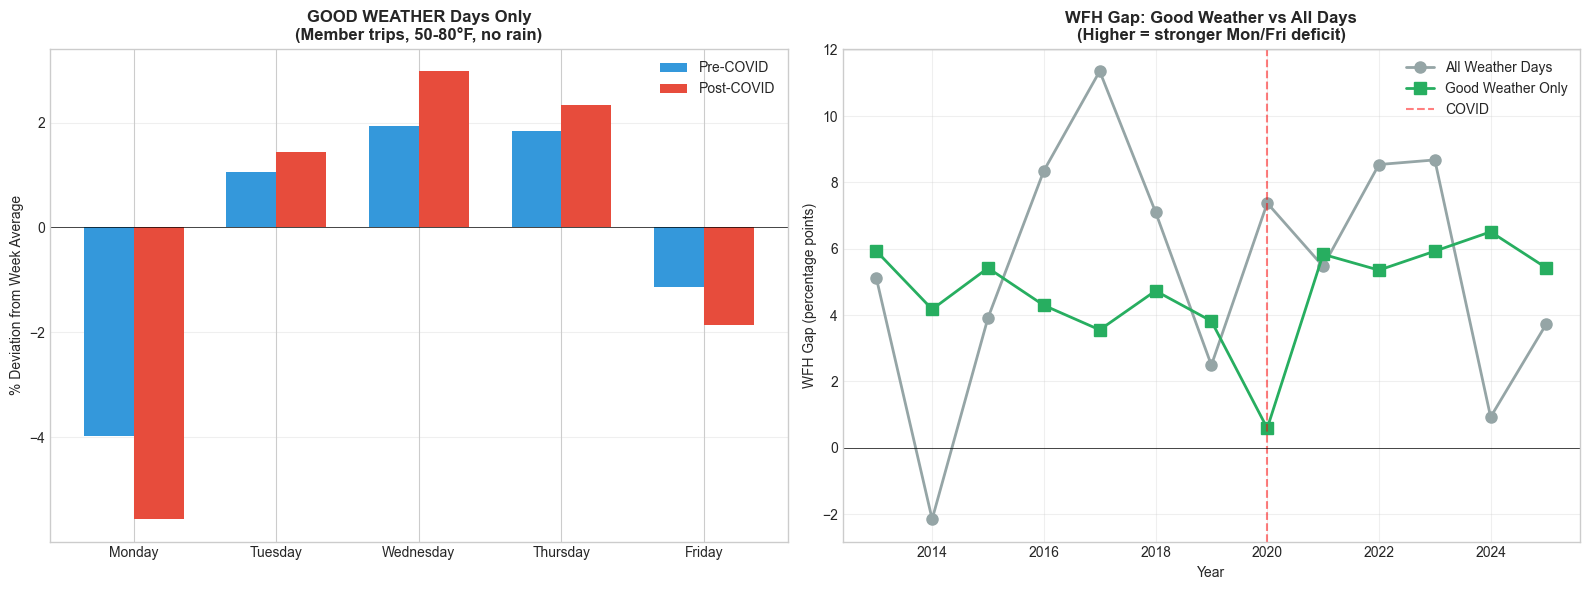


WFH Gap Comparison (percentage points):
Year     All Weather     Good Weather   
----------------------------------------
2019     2.5             3.8            
2020     7.4             0.6            
2021     5.5             5.8            
2022     8.5             5.4            
2023     8.7             5.9            
2024     0.9             6.5            
2025     3.7             5.4            


In [110]:
# Compare day-of-week patterns: ALL days vs GOOD WEATHER days

# Filter to weekdays
good_weekdays = good_weather_days[good_weather_days['dow'].isin([1, 2, 3, 4, 5])].copy()

# Normalize by week averages
weekly_avg_good = good_weekdays.groupby('year_week')['member_trips'].mean().reset_index()
weekly_avg_good.columns = ['year_week', 'week_avg']
good_weekdays = good_weekdays.merge(weekly_avg_good, on='year_week')
good_weekdays['pct_of_week_avg'] = good_weekdays['member_trips'] / good_weekdays['week_avg'] * 100

# Calculate day-of-week pattern for good weather days
good_weekdays['period'] = 'Pre-COVID'
good_weekdays.loc[good_weekdays['year'] >= 2022, 'period'] = 'Post-COVID'

dow_good_weather = good_weekdays.groupby(['period', 'dow']).agg({
    'pct_of_week_avg': 'mean'
}).reset_index()

# Map dow to day names
dow_map = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday'}
dow_good_weather['day_name'] = dow_good_weather['dow'].map(dow_map)

# Compare with all weather days
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Good weather: Pre vs Post COVID
ax = axes[0]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
x = np.arange(5)
width = 0.35

pre_data = dow_good_weather[dow_good_weather['period'] == 'Pre-COVID'].set_index('day_name').reindex(day_order)
post_data = dow_good_weather[dow_good_weather['period'] == 'Post-COVID'].set_index('day_name').reindex(day_order)

ax.bar(x - width/2, pre_data['pct_of_week_avg'] - 100, width, label='Pre-COVID', color='#3498db')
ax.bar(x + width/2, post_data['pct_of_week_avg'] - 100, width, label='Post-COVID', color='#e74c3c')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(day_order)
ax.set_ylabel('% Deviation from Week Average')
ax.set_title('GOOD WEATHER Days Only\n(Member trips, 50-80°F, no rain)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 2. Side-by-side: Good weather vs All weather WFH gap
ax = axes[1]

# Calculate WFH gap by year for good weather
yearly_good = good_weekdays.groupby(['year', 'dow'])['pct_of_week_avg'].mean().unstack()
yearly_good['Mon_Fri_avg'] = (yearly_good[1] + yearly_good[5]) / 2
yearly_good['Tue_Wed_Thu_avg'] = (yearly_good[2] + yearly_good[3] + yearly_good[4]) / 3
yearly_good['WFH_gap'] = yearly_good['Tue_Wed_Thu_avg'] - yearly_good['Mon_Fri_avg']

ax.plot(yearly_pivot.index, yearly_pivot['WFH_gap'], 'o-', linewidth=2, markersize=8, 
        label='All Weather Days', color='#95a5a6')
ax.plot(yearly_good.index, yearly_good['WFH_gap'], 's-', linewidth=2, markersize=8, 
        label='Good Weather Only', color='#27ae60')
ax.axvline(2020, color='red', linestyle='--', alpha=0.5, label='COVID')
ax.axhline(0, color='black', linewidth=0.5)

ax.set_xlabel('Year')
ax.set_ylabel('WFH Gap (percentage points)')
ax.set_title('WFH Gap: Good Weather vs All Days\n(Higher = stronger Mon/Fri deficit)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../logs/wfh_good_weather.png', dpi=150, bbox_inches='tight')
plt.show()

# Print comparison
print("\nWFH Gap Comparison (percentage points):")
print(f"{'Year':<8} {'All Weather':<15} {'Good Weather':<15}")
print("-" * 40)
for year in range(2019, 2026):
    all_gap = yearly_pivot.loc[year, 'WFH_gap'] if year in yearly_pivot.index else float('nan')
    good_gap = yearly_good.loc[year, 'WFH_gap'] if year in yearly_good.index else float('nan')
    print(f"{year:<8} {all_gap:<15.1f} {good_gap:<15.1f}")

---
## 7b. Focused WFH Analysis: Fall Morning Rush (Members Only)

**The purest commute signal**: Members biking to work in the morning during fall.

- **Members only**: Excludes tourists and casual riders
- **Morning rush only**: 7-9am (peak commute hours)
- **Fall only**: Sept-Nov (nice weather, no summer vacation, no winter cold)

This isolates the "going to work" behavior and should show the WFH effect most clearly.

In [111]:
# Get fall morning rush member trips by day
fall_morning_rush = con.execute("""
    SELECT 
        DATE(t.started_at) as date,
        EXTRACT(YEAR FROM t.started_at) as year,
        EXTRACT(DOW FROM t.started_at) as dow,
        CASE EXTRACT(DOW FROM t.started_at)
            WHEN 0 THEN 'Sunday'
            WHEN 1 THEN 'Monday'
            WHEN 2 THEN 'Tuesday'
            WHEN 3 THEN 'Wednesday'
            WHEN 4 THEN 'Thursday'
            WHEN 5 THEN 'Friday'
            WHEN 6 THEN 'Saturday'
        END as day_name,
        COUNT(*) as trips,
        AVG(w.temperature_2m) * 9/5 + 32 as temp_f,
        MAX(w.precipitation) as precip_mm
    FROM '../data/processed/*.parquet' t
    LEFT JOIN '../data/weather/hourly_weather.parquet' w
        ON DATE_TRUNC('hour', t.started_at) = w.datetime
    WHERE t.member_casual = 'member'
      AND EXTRACT(HOUR FROM t.started_at) BETWEEN 7 AND 9      -- Morning rush: 7am-9am
      AND EXTRACT(MONTH FROM t.started_at) IN (9, 10, 11)      -- Fall: Sept, Oct, Nov
      AND EXTRACT(DOW FROM t.started_at) BETWEEN 1 AND 5       -- Weekdays only
    GROUP BY 1, 2, 3, 4
    ORDER BY 1
""").fetchdf()

fall_morning_rush['date'] = pd.to_datetime(fall_morning_rush['date'])

# Calculate period
fall_morning_rush['period'] = 'Pre-COVID'
fall_morning_rush.loc[fall_morning_rush['year'] == 2020, 'period'] = 'COVID-2020'
fall_morning_rush.loc[fall_morning_rush['year'] == 2021, 'period'] = 'Recovery-2021'
fall_morning_rush.loc[fall_morning_rush['year'] >= 2022, 'period'] = 'Post-COVID'

print(f"Fall Morning Rush Analysis (Members, 7-9am, Sept-Nov, Weekdays)")
print("="*60)
print(f"Total days: {len(fall_morning_rush):,}")
print(f"Total trips: {fall_morning_rush['trips'].sum():,}")
print(f"\nBy period:")
print(fall_morning_rush.groupby('period')['trips'].agg(['count', 'sum', 'mean']).round(0))

Fall Morning Rush Analysis (Members, 7-9am, Sept-Nov, Weekdays)
Total days: 845
Total trips: 11,731,732

By period:
               count      sum     mean
period                                
COVID-2020        65   575572   8855.0
Post-COVID       260  5482336  21086.0
Pre-COVID        455  4820044  10594.0
Recovery-2021     65   853780  13135.0


In [112]:
# Normalize by week averages to control for system growth
fall_morning_rush['week'] = fall_morning_rush['date'].dt.isocalendar().week
fall_morning_rush['year_week'] = fall_morning_rush['year'].astype(str) + '-' + fall_morning_rush['week'].astype(str)

weekly_avg = fall_morning_rush.groupby('year_week')['trips'].mean().reset_index()
weekly_avg.columns = ['year_week', 'week_avg']
fall_morning_rush = fall_morning_rush.merge(weekly_avg, on='year_week')
fall_morning_rush['pct_of_week_avg'] = fall_morning_rush['trips'] / fall_morning_rush['week_avg'] * 100

# Day-of-week pattern by period
dow_pattern = fall_morning_rush.groupby(['period', 'day_name']).agg({
    'pct_of_week_avg': 'mean',
    'trips': 'mean'
}).reset_index()

# Order days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
dow_pattern['day_name'] = pd.Categorical(dow_pattern['day_name'], categories=day_order, ordered=True)
dow_pattern = dow_pattern.sort_values(['period', 'day_name'])

# Pivot for visualization
pivot = dow_pattern.pivot(index='day_name', columns='period', values='pct_of_week_avg')
pivot = pivot.reindex(columns=['Pre-COVID', 'COVID-2020', 'Recovery-2021', 'Post-COVID'])

print("\nDay-of-Week Pattern (% of week average):")
print("FALL MORNING RUSH ONLY (Members, 7-9am, Sept-Nov)")
print("-"*60)
print(pivot.round(1))

# Calculate WFH gap
print("\n" + "="*60)
print("WFH GAP ANALYSIS (Tue-Wed-Thu avg - Mon-Fri avg)")
print("="*60)
for period in ['Pre-COVID', 'Post-COVID']:
    if period in pivot.columns:
        mon = pivot.loc['Monday', period]
        tue = pivot.loc['Tuesday', period]
        wed = pivot.loc['Wednesday', period]
        thu = pivot.loc['Thursday', period]
        fri = pivot.loc['Friday', period]
        
        mon_fri = (mon + fri) / 2
        tue_wed_thu = (tue + wed + thu) / 3
        gap = tue_wed_thu - mon_fri
        
        print(f"\n{period}:")
        print(f"  Mon/Fri avg:     {mon_fri:.1f}%")
        print(f"  Tue/Wed/Thu avg: {tue_wed_thu:.1f}%")
        print(f"  WFH Gap:         {gap:+.1f} pp")


Day-of-Week Pattern (% of week average):
FALL MORNING RUSH ONLY (Members, 7-9am, Sept-Nov)
------------------------------------------------------------
period     Pre-COVID  COVID-2020  Recovery-2021  Post-COVID
day_name                                                   
Monday          92.0        89.9           93.8        90.2
Tuesday        108.6       115.3          105.8       109.7
Wednesday      107.5       111.5          110.6       110.1
Thursday        96.4        94.0          100.7       104.4
Friday          95.6        89.3           89.2        85.6

WFH GAP ANALYSIS (Tue-Wed-Thu avg - Mon-Fri avg)

Pre-COVID:
  Mon/Fri avg:     93.8%
  Tue/Wed/Thu avg: 104.2%
  WFH Gap:         +10.4 pp

Post-COVID:
  Mon/Fri avg:     87.9%
  Tue/Wed/Thu avg: 108.1%
  WFH Gap:         +20.2 pp


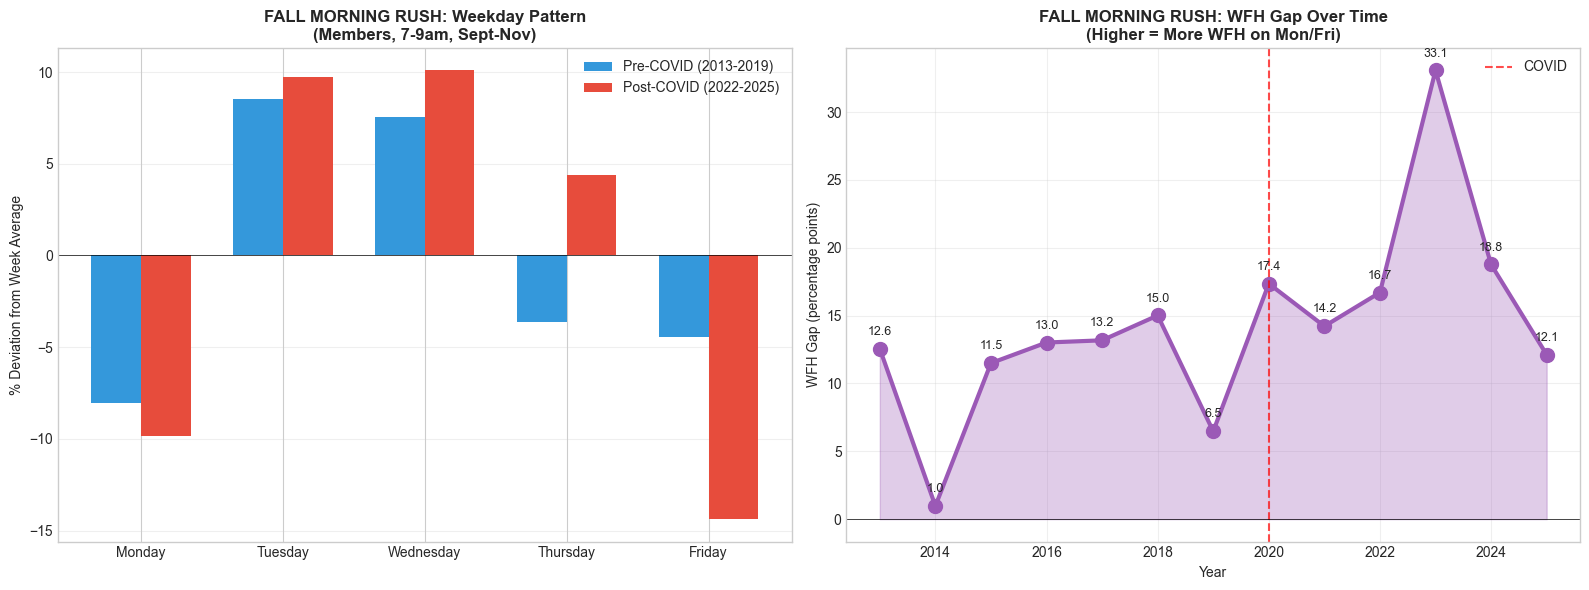


Fall Morning Rush WFH Gap by Year:
day_name  Mon_Fri_avg  Tue_Wed_Thu_avg  WFH_gap
year                                           
2013             92.5            105.0     12.6
2014             99.4            100.4      1.0
2015             93.1            104.6     11.5
2016             92.2            105.2     13.0
2017             92.1            105.3     13.2
2018             91.0            106.0     15.0
2019             96.1            102.6      6.5
2020             89.6            106.9     17.4
2021             91.5            105.7     14.2
2022             90.0            106.7     16.7
2023             80.2            113.2     33.1
2024             88.7            107.5     18.8
2025             92.7            104.8     12.1


In [113]:
# Visualize fall morning rush WFH pattern
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Day of week pattern: Pre vs Post COVID
ax = axes[0]
x = np.arange(5)
width = 0.35

pre_data = pivot['Pre-COVID'].values if 'Pre-COVID' in pivot.columns else np.zeros(5)
post_data = pivot['Post-COVID'].values if 'Post-COVID' in pivot.columns else np.zeros(5)

ax.bar(x - width/2, pre_data - 100, width, label='Pre-COVID (2013-2019)', color='#3498db')
ax.bar(x + width/2, post_data - 100, width, label='Post-COVID (2022-2025)', color='#e74c3c')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(day_order)
ax.set_ylabel('% Deviation from Week Average')
ax.set_title('FALL MORNING RUSH: Weekday Pattern\n(Members, 7-9am, Sept-Nov)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 2. Year-by-year WFH gap trend
ax = axes[1]

# Calculate gap by year
yearly_dow = fall_morning_rush.groupby(['year', 'day_name'])['pct_of_week_avg'].mean().unstack()
yearly_dow['Mon_Fri_avg'] = (yearly_dow['Monday'] + yearly_dow['Friday']) / 2
yearly_dow['Tue_Wed_Thu_avg'] = (yearly_dow['Tuesday'] + yearly_dow['Wednesday'] + yearly_dow['Thursday']) / 3
yearly_dow['WFH_gap'] = yearly_dow['Tue_Wed_Thu_avg'] - yearly_dow['Mon_Fri_avg']

ax.plot(yearly_dow.index, yearly_dow['WFH_gap'], 'o-', linewidth=3, markersize=10, color='#9b59b6')
ax.fill_between(yearly_dow.index, 0, yearly_dow['WFH_gap'], alpha=0.3, color='#9b59b6')
ax.axvline(2020, color='red', linestyle='--', alpha=0.7, label='COVID')
ax.axhline(0, color='black', linewidth=0.5)

ax.set_xlabel('Year')
ax.set_ylabel('WFH Gap (percentage points)')
ax.set_title('FALL MORNING RUSH: WFH Gap Over Time\n(Higher = More WFH on Mon/Fri)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels
for year, gap in zip(yearly_dow.index, yearly_dow['WFH_gap']):
    ax.annotate(f'{gap:.1f}', xy=(year, gap), xytext=(0, 10), 
                textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../logs/wfh_fall_morning_rush.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFall Morning Rush WFH Gap by Year:")
print(yearly_dow[['Mon_Fri_avg', 'Tue_Wed_Thu_avg', 'WFH_gap']].round(1))

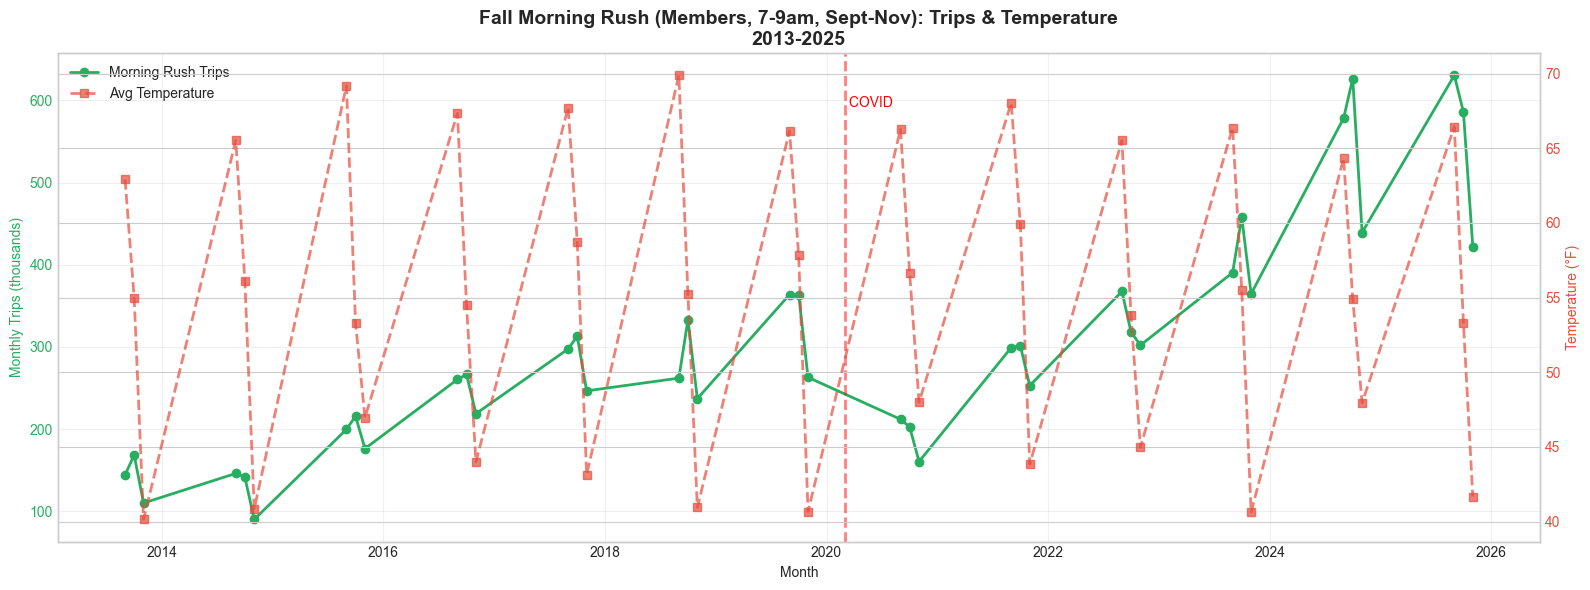


Correlation between temperature and trips: r = 0.189
(Within fall months, temperature variation is smaller, so correlation may be weaker)


In [114]:
# Line graph: Fall morning rush trips and temperature over time
# Aggregate by month for cleaner visualization
fall_monthly = fall_morning_rush.copy()
fall_monthly['month'] = fall_monthly['date'].dt.to_period('M')

monthly_agg = fall_monthly.groupby('month').agg({
    'trips': 'sum',
    'temp_f': 'mean'
}).reset_index()
monthly_agg['month'] = monthly_agg['month'].dt.to_timestamp()

# Plot
fig, ax1 = plt.subplots(figsize=(16, 6))

# Trips line
ax1.plot(monthly_agg['month'], monthly_agg['trips']/1000, 
         'o-', linewidth=2, markersize=6, color='#27ae60', label='Morning Rush Trips')
ax1.set_xlabel('Month')
ax1.set_ylabel('Monthly Trips (thousands)', color='#27ae60')
ax1.tick_params(axis='y', labelcolor='#27ae60')
ax1.grid(True, alpha=0.3)

# Temperature line (secondary axis)
ax2 = ax1.twinx()
ax2.plot(monthly_agg['month'], monthly_agg['temp_f'], 
         's--', linewidth=2, markersize=6, color='#e74c3c', alpha=0.7, label='Avg Temperature')
ax2.set_ylabel('Temperature (°F)', color='#e74c3c')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

# COVID marker
ax1.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', alpha=0.5, linewidth=2)
ax1.text(pd.Timestamp('2020-03-01'), ax1.get_ylim()[1]*0.9, ' COVID', fontsize=10, color='red')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Fall Morning Rush (Members, 7-9am, Sept-Nov): Trips & Temperature\n2013-2025', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../logs/fall_morning_rush_trend.png', dpi=150, bbox_inches='tight')
plt.show()

# Correlation
corr = monthly_agg['trips'].corr(monthly_agg['temp_f'])
print(f"\nCorrelation between temperature and trips: r = {corr:.3f}")
print("(Within fall months, temperature variation is smaller, so correlation may be weaker)")

---
## 9. Weather Effects Controlled for Day of Week

**Isolating the weather impact**: How do temperature and rain affect ridership, removing the day-of-week pattern?

We'll:
1. Calculate "expected" rides for each day of week
2. Show actual rides as % of expected
3. Plot against temperature and precipitation

In [115]:
# Get daily data with weather for DOW-controlled analysis
weather_control = con.execute("""
    SELECT 
        DATE(t.started_at) as date,
        EXTRACT(YEAR FROM t.started_at) as year,
        EXTRACT(DOW FROM t.started_at) as dow,
        COUNT(*) as total_trips,
        COUNT(*) FILTER (WHERE t.member_casual = 'member') as member_trips,
        AVG(w.apparent_temperature) * 9/5 + 32 as feels_like_f,
        AVG(w.temperature_2m) * 9/5 + 32 as temp_f,
        SUM(w.precipitation) as total_precip_mm,
        MAX(CASE WHEN w.precipitation > 0 THEN 1 ELSE 0 END) as had_rain
    FROM '../data/processed/*.parquet' t
    LEFT JOIN '../data/weather/hourly_weather.parquet' w
        ON DATE_TRUNC('hour', t.started_at) = w.datetime
    WHERE EXTRACT(YEAR FROM t.started_at) >= 2022  -- Post-COVID for cleaner signal
    GROUP BY 1, 2, 3
""").fetchdf()

weather_control['date'] = pd.to_datetime(weather_control['date'])

# Calculate expected trips for each DOW (controlling for day of week)
dow_avg = weather_control.groupby('dow')['member_trips'].mean()
weather_control['expected_trips'] = weather_control['dow'].map(dow_avg)
weather_control['pct_of_expected'] = weather_control['member_trips'] / weather_control['expected_trips'] * 100

# Create temperature bins
weather_control['temp_bin'] = pd.cut(weather_control['feels_like_f'], 
                                      bins=[0, 32, 45, 55, 65, 75, 85, 100],
                                      labels=['<32°F', '32-45°F', '45-55°F', '55-65°F', '65-75°F', '75-85°F', '85°F+'])

# Create rain categories
weather_control['rain_cat'] = 'No Rain'
weather_control.loc[weather_control['total_precip_mm'] > 0, 'rain_cat'] = 'Light Rain'
weather_control.loc[weather_control['total_precip_mm'] > 5, 'rain_cat'] = 'Moderate Rain'
weather_control.loc[weather_control['total_precip_mm'] > 15, 'rain_cat'] = 'Heavy Rain'

print(f"Days analyzed: {len(weather_control):,} (2022-2025)")
print(f"\nTemperature distribution:")
print(weather_control['temp_bin'].value_counts().sort_index())
print(f"\nRain distribution:")
print(weather_control['rain_cat'].value_counts())

Days analyzed: 1,430 (2022-2025)

Temperature distribution:
temp_bin
<32°F      271
32-45°F    277
45-55°F    181
55-65°F    182
65-75°F    216
75-85°F    203
85°F+       99
Name: count, dtype: int64

Rain distribution:
rain_cat
No Rain       730
Heavy Rain    700
Name: count, dtype: int64


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


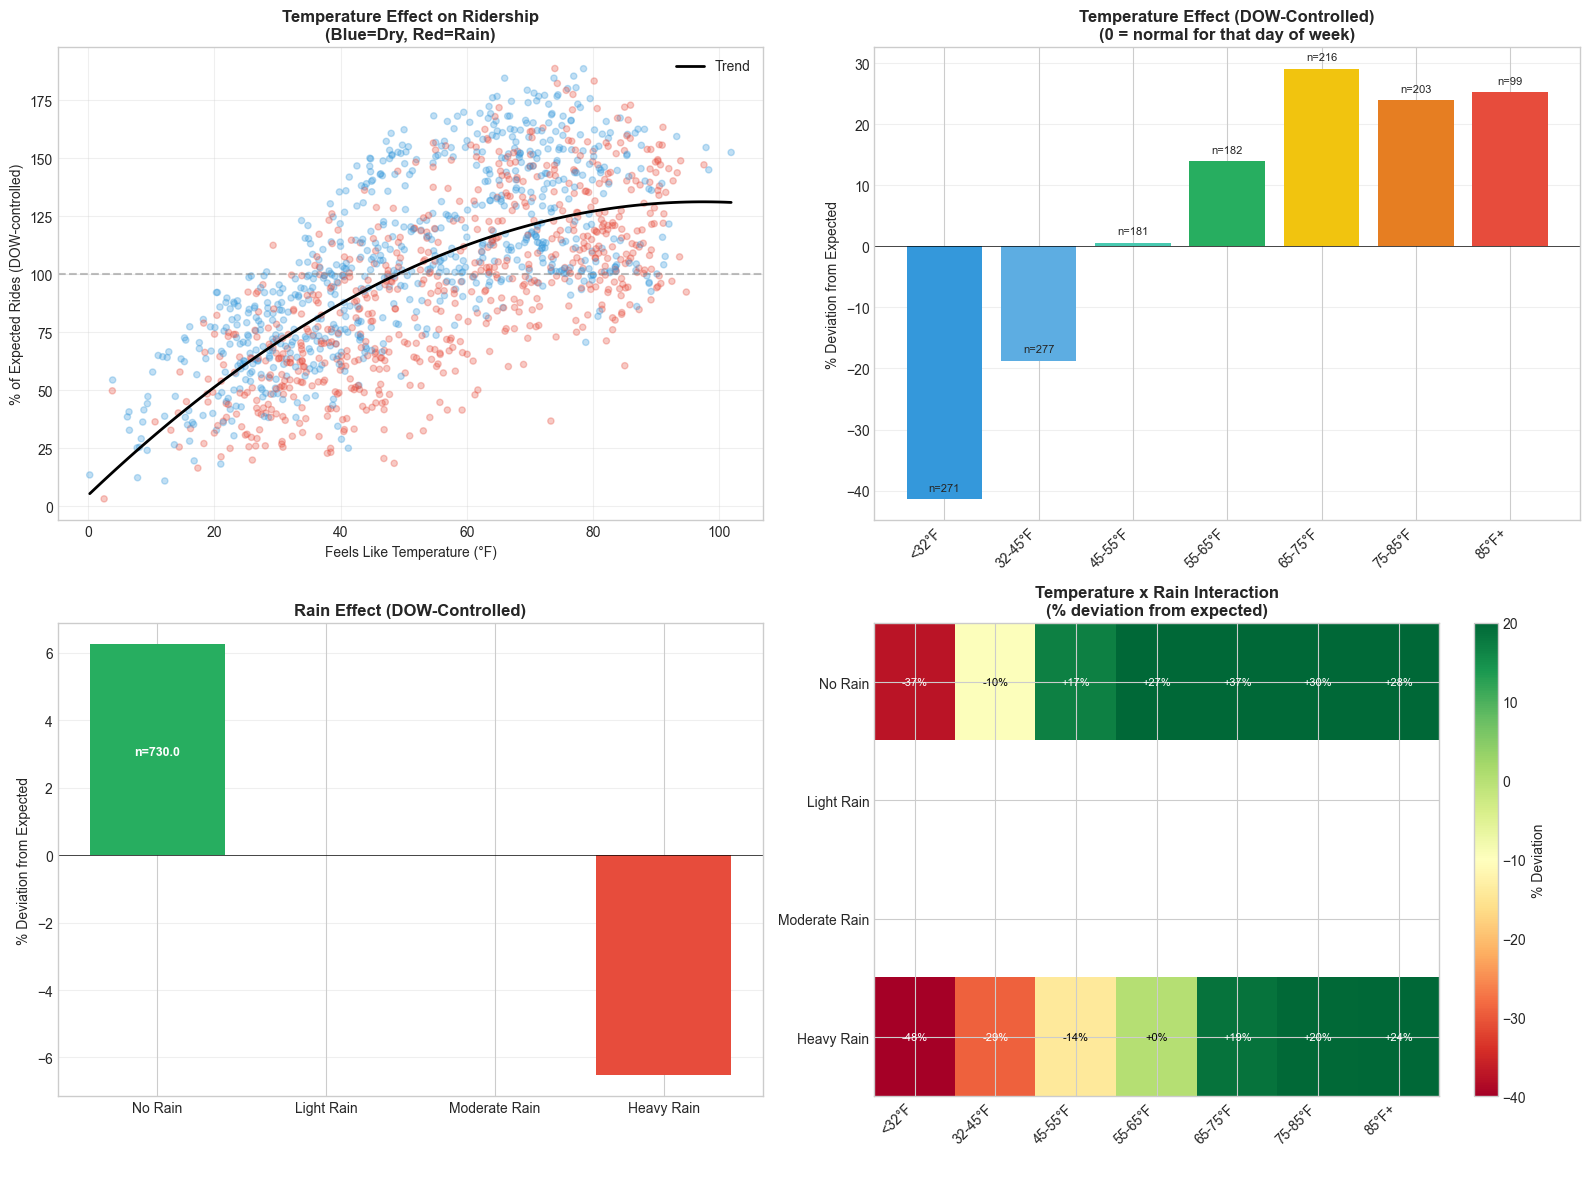


KEY FINDINGS (DOW-Controlled):
  Optimal temperature: 65-75°F → +29.2% above expected
  Cold (<32°F): -41.4% vs expected
  Heavy rain: -6.5% vs expected


In [116]:
# Visualize weather effects (controlled for day of week)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Rides vs Temperature (Feels Like) - scatter with trend
ax = axes[0, 0]
ax.scatter(weather_control['feels_like_f'], weather_control['pct_of_expected'], 
           alpha=0.3, s=20, c=weather_control['had_rain'].map({0: '#3498db', 1: '#e74c3c'}))
# Add trend line
z = np.polyfit(weather_control['feels_like_f'].dropna(), 
               weather_control.loc[weather_control['feels_like_f'].notna(), 'pct_of_expected'], 2)
p = np.poly1d(z)
x_line = np.linspace(weather_control['feels_like_f'].min(), weather_control['feels_like_f'].max(), 100)
ax.plot(x_line, p(x_line), 'k-', linewidth=2, label='Trend')
ax.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Feels Like Temperature (°F)')
ax.set_ylabel('% of Expected Rides (DOW-controlled)')
ax.set_title('Temperature Effect on Ridership\n(Blue=Dry, Red=Rain)', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Average rides by temperature bin
ax = axes[0, 1]
temp_effect = weather_control.groupby('temp_bin')['pct_of_expected'].agg(['mean', 'std', 'count']).reset_index()
colors = ['#3498db', '#5dade2', '#48c9b0', '#27ae60', '#f1c40f', '#e67e22', '#e74c3c']
bars = ax.bar(range(len(temp_effect)), temp_effect['mean'] - 100, color=colors[:len(temp_effect)])
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(range(len(temp_effect)))
ax.set_xticklabels(temp_effect['temp_bin'], rotation=45, ha='right')
ax.set_ylabel('% Deviation from Expected')
ax.set_title('Temperature Effect (DOW-Controlled)\n(0 = normal for that day of week)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
# Add count labels
for i, (bar, count) in enumerate(zip(bars, temp_effect['count'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'n={count}', 
            ha='center', va='bottom', fontsize=8)

# 3. Rain effect
ax = axes[1, 0]
rain_order = ['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain']
rain_effect = weather_control.groupby('rain_cat')['pct_of_expected'].agg(['mean', 'count']).reindex(rain_order)
colors = ['#27ae60', '#f1c40f', '#e67e22', '#e74c3c']
bars = ax.bar(range(len(rain_effect)), rain_effect['mean'] - 100, color=colors)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(range(len(rain_effect)))
ax.set_xticklabels(rain_order)
ax.set_ylabel('% Deviation from Expected')
ax.set_title('Rain Effect (DOW-Controlled)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, count) in enumerate(zip(bars, rain_effect['count'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 3, f'n={count}', 
            ha='center', va='top', fontsize=9, color='white', fontweight='bold')

# 4. Combined: Temperature + Rain interaction
ax = axes[1, 1]
# Heatmap of temp bin x rain category
pivot_heat = weather_control.pivot_table(values='pct_of_expected', 
                                          index='rain_cat', 
                                          columns='temp_bin', 
                                          aggfunc='mean')
pivot_heat = pivot_heat.reindex(rain_order)
im = ax.imshow(pivot_heat.values - 100, cmap='RdYlGn', aspect='auto', vmin=-40, vmax=20)
ax.set_xticks(range(len(pivot_heat.columns)))
ax.set_xticklabels(pivot_heat.columns, rotation=45, ha='right')
ax.set_yticks(range(len(pivot_heat.index)))
ax.set_yticklabels(pivot_heat.index)
ax.set_title('Temperature x Rain Interaction\n(% deviation from expected)', fontweight='bold')
plt.colorbar(im, ax=ax, label='% Deviation')
# Add text annotations
for i in range(len(pivot_heat.index)):
    for j in range(len(pivot_heat.columns)):
        val = pivot_heat.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f'{val-100:+.0f}%', ha='center', va='center', fontsize=8,
                   color='white' if abs(val-100) > 15 else 'black')

plt.tight_layout()
plt.savefig('../logs/weather_effects_controlled.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKEY FINDINGS (DOW-Controlled):")
print(f"  Optimal temperature: 65-75°F → {temp_effect[temp_effect['temp_bin']=='65-75°F']['mean'].values[0]-100:+.1f}% above expected")
print(f"  Cold (<32°F): {temp_effect[temp_effect['temp_bin']=='<32°F']['mean'].values[0]-100:+.1f}% vs expected")
print(f"  Heavy rain: {rain_effect.loc['Heavy Rain', 'mean']-100:+.1f}% vs expected")

---
## 10. Hourly Deep Dive: Individual Days

**See how rides and rain move together hour-by-hour on specific days.**

Change the `SAMPLE_DATES` below to explore different days!

In [117]:
###############################################################################
#  🔧 CONFIGURE SAMPLE DATES TO EXPLORE
#  Pick any dates you want to compare!
###############################################################################

# Example: Compare a rainy day vs a nice day in the same week
SAMPLE_DATES = [
    '2024-09-25',  # A rainy Wednesday
    '2024-09-26',  # The next day (dry)
    '2024-10-07',  # A nice fall Monday
]

# Other interesting dates to try:
# - '2024-07-04' (July 4th holiday)
# - '2024-01-15' (cold winter day)
# - '2024-06-01' (start of summer)

###############################################################################

print(f"Analyzing hourly patterns for: {SAMPLE_DATES}")

Analyzing hourly patterns for: ['2024-09-25', '2024-09-26', '2024-10-07']


In [118]:
# Get hourly data for sample dates
dates_str = "', '".join(SAMPLE_DATES)
hourly_data = con.execute(f"""
    SELECT 
        DATE(t.started_at) as date,
        EXTRACT(HOUR FROM t.started_at) as hour,
        COUNT(*) as total_trips,
        COUNT(*) FILTER (WHERE t.member_casual = 'member') as member_trips,
        COUNT(*) FILTER (WHERE t.member_casual = 'casual') as casual_trips,
        AVG(w.apparent_temperature) * 9/5 + 32 as feels_like_f,
        AVG(w.precipitation) as precip_mm
    FROM '../data/processed/*.parquet' t
    LEFT JOIN '../data/weather/hourly_weather.parquet' w
        ON DATE_TRUNC('hour', t.started_at) = w.datetime
    WHERE DATE(t.started_at) IN ('{dates_str}')
    GROUP BY 1, 2
    ORDER BY 1, 2
""").fetchdf()

hourly_data['date'] = pd.to_datetime(hourly_data['date'])

# Get day of week names
dow_names = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

# Summary stats
print("HOURLY DATA SUMMARY")
print("="*70)
for date in sorted(hourly_data['date'].unique()):
    day_data = hourly_data[hourly_data['date'] == date]
    dow = dow_names[date.dayofweek]  # Fixed: no parentheses
    total = day_data['total_trips'].sum()
    avg_temp = day_data['feels_like_f'].mean()
    total_rain = day_data['precip_mm'].sum()
    print(f"{date.strftime('%Y-%m-%d')} ({dow}): {total:,} trips | {avg_temp:.0f}°F avg | {total_rain:.1f}mm rain")

HOURLY DATA SUMMARY
2024-09-25 (Wed): 169,933 trips | 61°F avg | 0.9mm rain
2024-09-26 (Thu): 157,675 trips | 71°F avg | 4.4mm rain
2024-10-07 (Mon): 160,375 trips | 62°F avg | 6.2mm rain


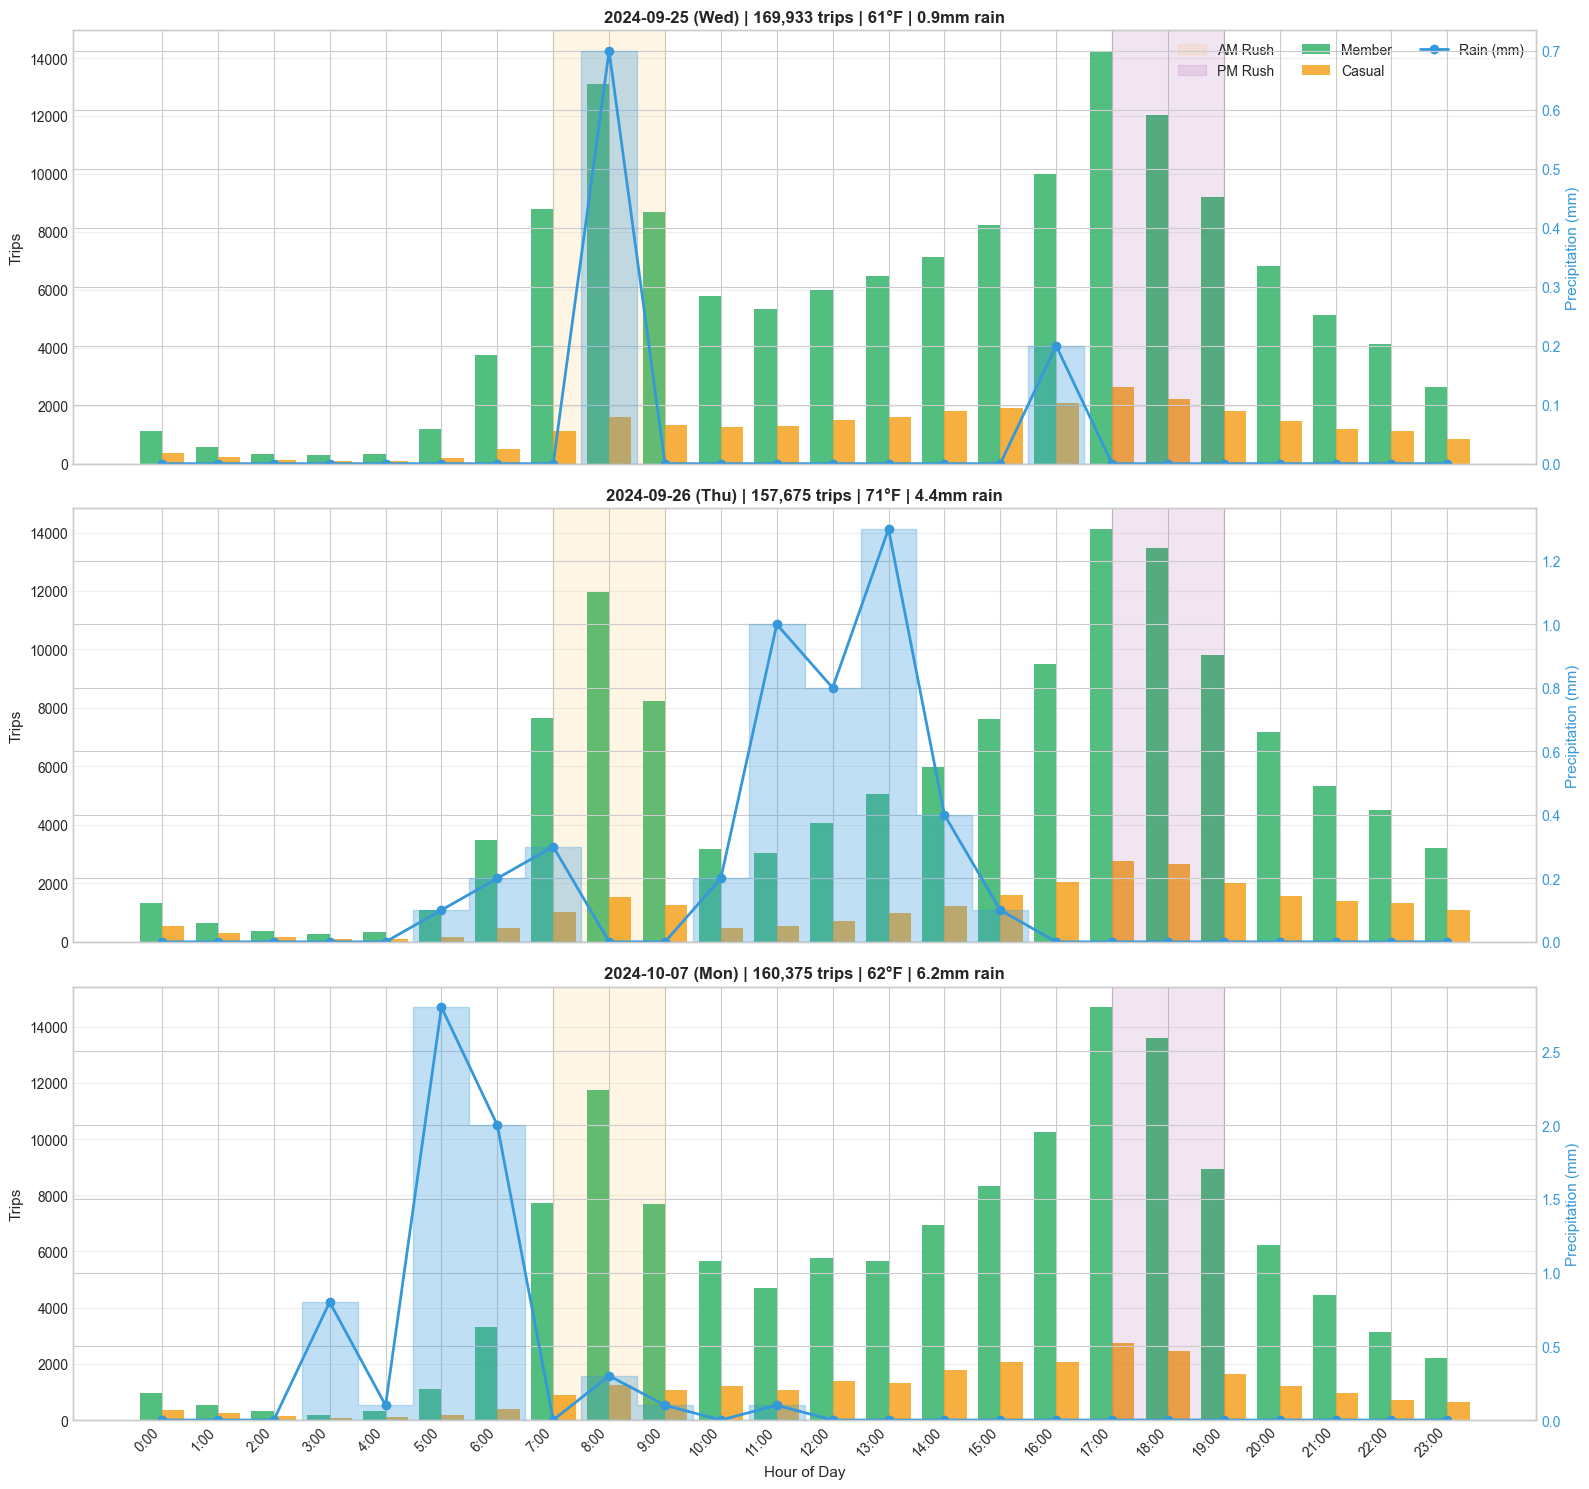

In [119]:
# Create hourly comparison charts for each day
n_days = len(SAMPLE_DATES)
fig, axes = plt.subplots(n_days, 1, figsize=(16, 5*n_days), sharex=True)

if n_days == 1:
    axes = [axes]

colors = ['#3498db', '#e74c3c', '#27ae60', '#9b59b6', '#f39c12']

for idx, date_str in enumerate(SAMPLE_DATES):
    date = pd.to_datetime(date_str)
    day_data = hourly_data[hourly_data['date'] == date].sort_values('hour')
    
    if len(day_data) == 0:
        print(f"No data for {date_str}")
        continue
    
    ax1 = axes[idx]
    dow = dow_names[date.dayofweek]  # Fixed: no parentheses
    
    # Plot rides (left axis)
    ax1.bar(day_data['hour'] - 0.2, day_data['member_trips'], 0.4, 
            label='Member', color='#27ae60', alpha=0.8)
    ax1.bar(day_data['hour'] + 0.2, day_data['casual_trips'], 0.4, 
            label='Casual', color='#f39c12', alpha=0.8)
    ax1.set_ylabel('Trips', fontsize=11)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot rain (right axis)
    ax2 = ax1.twinx()
    ax2.fill_between(day_data['hour'], 0, day_data['precip_mm'], 
                     alpha=0.3, color='#3498db', step='mid')
    ax2.plot(day_data['hour'], day_data['precip_mm'], 
             'o-', color='#3498db', linewidth=2, markersize=6, label='Rain (mm)')
    ax2.set_ylabel('Precipitation (mm)', color='#3498db', fontsize=11)
    ax2.tick_params(axis='y', labelcolor='#3498db')
    ax2.set_ylim(bottom=0)
    
    # Title with summary stats
    total_trips = day_data['total_trips'].sum()
    total_rain = day_data['precip_mm'].sum()
    avg_temp = day_data['feels_like_f'].mean()
    title = f"{date_str} ({dow}) | {total_trips:,} trips | {avg_temp:.0f}°F | {total_rain:.1f}mm rain"
    ax1.set_title(title, fontsize=12, fontweight='bold')
    
    # Highlight rush hours
    ax1.axvspan(7, 9, alpha=0.1, color='orange', label='AM Rush')
    ax1.axvspan(17, 19, alpha=0.1, color='purple', label='PM Rush')
    
    # Legend on first plot only
    if idx == 0:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', ncol=3)

# X-axis labels on bottom plot
axes[-1].set_xlabel('Hour of Day', fontsize=11)
axes[-1].set_xticks(range(0, 24))
axes[-1].set_xticklabels([f'{h}:00' for h in range(24)], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../logs/hourly_weather_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

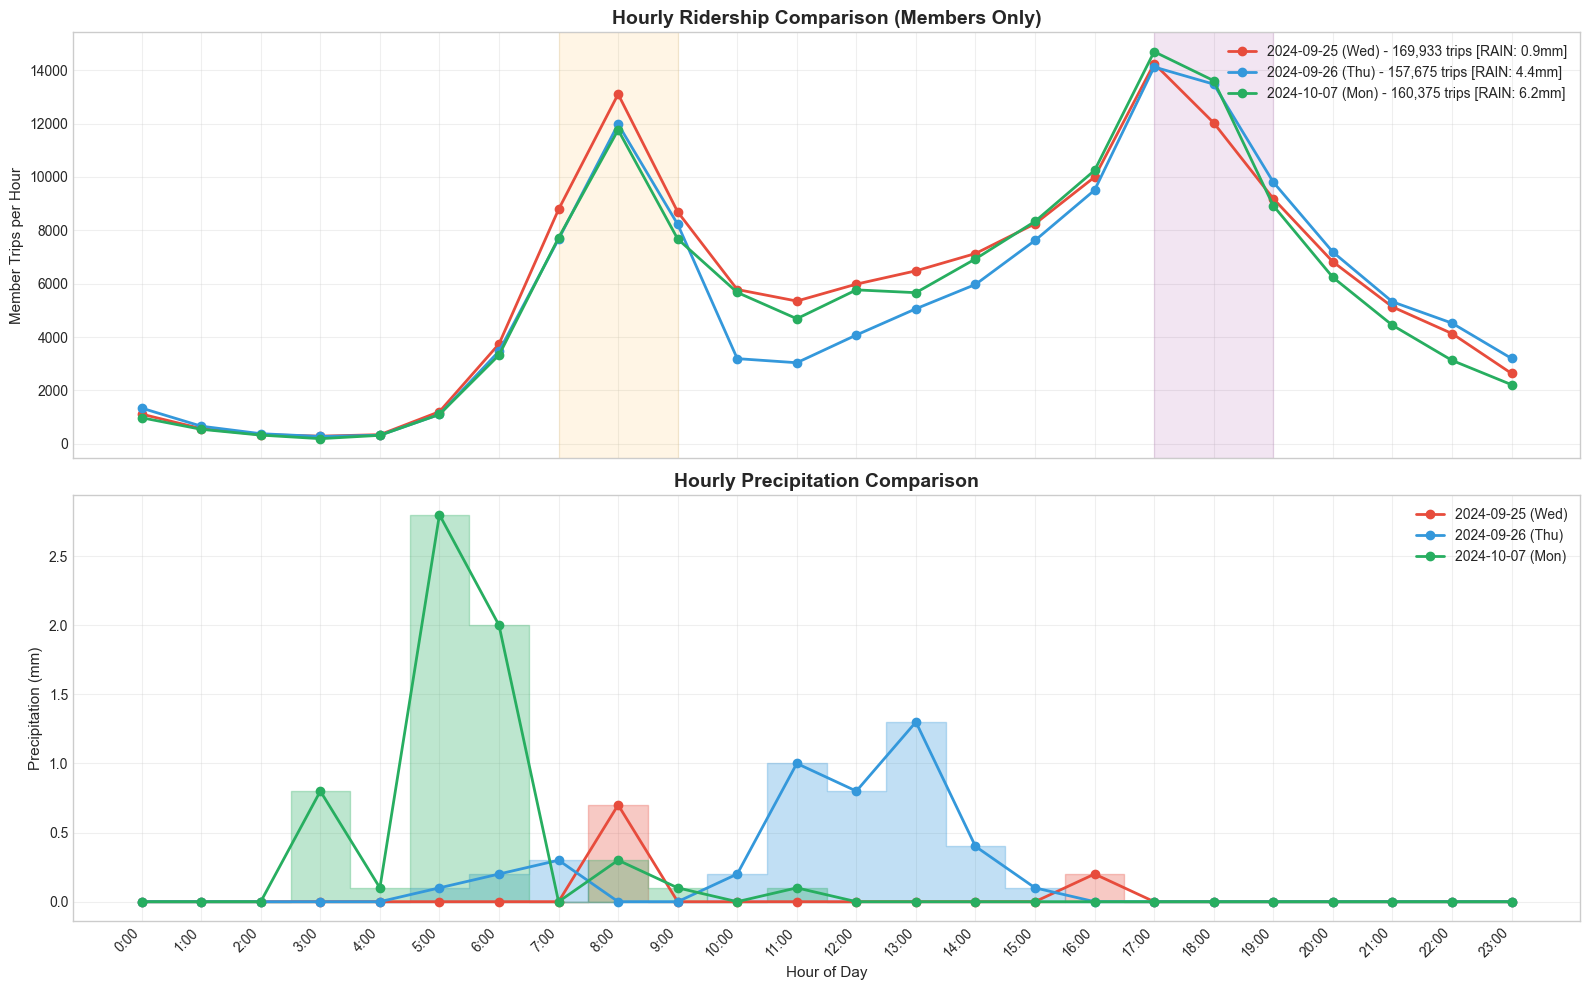


Observation: Look at how ridership dips during rainy hours vs dry hours!
The evening rush (5-7pm) is often more affected than morning rush.


In [120]:
# Overlay all days on one chart for easy comparison
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

colors = ['#e74c3c', '#3498db', '#27ae60', '#9b59b6', '#f39c12']

# Panel 1: Rides by hour (all days overlaid)
ax = axes[0]
for idx, date_str in enumerate(SAMPLE_DATES):
    date = pd.to_datetime(date_str)
    day_data = hourly_data[hourly_data['date'] == date].sort_values('hour')
    dow = dow_names[date.dayofweek]  # Fixed: no parentheses
    
    total = day_data['total_trips'].sum()
    rain = day_data['precip_mm'].sum()
    label = f"{date_str} ({dow}) - {total:,} trips"
    if rain > 0:
        label += f" [RAIN: {rain:.1f}mm]"
    
    ax.plot(day_data['hour'], day_data['member_trips'], 'o-', 
            linewidth=2, markersize=6, color=colors[idx % len(colors)], label=label)

ax.axvspan(7, 9, alpha=0.1, color='orange')
ax.axvspan(17, 19, alpha=0.1, color='purple')
ax.set_ylabel('Member Trips per Hour', fontsize=11)
ax.set_title('Hourly Ridership Comparison (Members Only)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 2: Precipitation by hour (all days overlaid)
ax = axes[1]
for idx, date_str in enumerate(SAMPLE_DATES):
    date = pd.to_datetime(date_str)
    day_data = hourly_data[hourly_data['date'] == date].sort_values('hour')
    dow = dow_names[date.dayofweek]  # Fixed: no parentheses
    
    ax.fill_between(day_data['hour'], 0, day_data['precip_mm'], 
                    alpha=0.3, color=colors[idx % len(colors)], step='mid')
    ax.plot(day_data['hour'], day_data['precip_mm'], 'o-', 
            linewidth=2, markersize=6, color=colors[idx % len(colors)], 
            label=f"{date_str} ({dow})")

ax.set_xlabel('Hour of Day', fontsize=11)
ax.set_ylabel('Precipitation (mm)', fontsize=11)
ax.set_title('Hourly Precipitation Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))
ax.set_xticklabels([f'{h}:00' for h in range(24)], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../logs/hourly_overlay_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nObservation: Look at how ridership dips during rainy hours vs dry hours!")
print("The evening rush (5-7pm) is often more affected than morning rush.")

---
## 8. Day-by-Day Weather + Ridership Explorer

**Choose a time period** to see daily weather and ridership patterns side by side.

This helps you understand:
- How temperature and precipitation affect daily ridership
- How member vs casual patterns differ in response to weather
- Day-to-day variation within a specific period

In [121]:
###############################################################################
#  🔧 CONFIGURE YOUR DATE RANGE HERE
#  Change these dates to explore different periods!
###############################################################################

START_DATE = '2025-09-20'   # Start of your analysis period
END_DATE = '2025-10-15'     # End of your analysis period

# Example periods to try:
# - Summer 2024:     '2024-06-01' to '2024-08-31'
# - COVID peak:      '2020-03-01' to '2020-05-31'
# - Winter week:     '2024-01-15' to '2024-01-21'
# - Fall commute:    '2023-09-01' to '2023-09-30'

###############################################################################

print(f"Analyzing period: {START_DATE} to {END_DATE}")
print("Change the dates above and re-run this cell to explore different periods!")

Analyzing period: 2025-09-20 to 2025-10-15
Change the dates above and re-run this cell to explore different periods!


In [122]:
# Query daily data with weather for the selected period
explorer_data = con.execute(f"""
    SELECT 
        DATE(t.started_at) as date,
        EXTRACT(DOW FROM t.started_at) as dow,
        CASE EXTRACT(DOW FROM t.started_at)
            WHEN 0 THEN 'Sun' WHEN 1 THEN 'Mon' WHEN 2 THEN 'Tue' 
            WHEN 3 THEN 'Wed' WHEN 4 THEN 'Thu' WHEN 5 THEN 'Fri' WHEN 6 THEN 'Sat'
        END as day_name,
        COUNT(*) as total_trips,
        COUNT(*) FILTER (WHERE t.member_casual = 'member') as member_trips,
        COUNT(*) FILTER (WHERE t.member_casual = 'casual') as casual_trips,
        AVG(w.temperature_2m) * 9/5 + 32 as temp_f,
        AVG(w.apparent_temperature) * 9/5 + 32 as feels_like_f,
        SUM(w.precipitation) / COUNT(DISTINCT DATE_TRUNC('hour', t.started_at)) as avg_precip_mm,
        MAX(CASE WHEN h.holiday_name IS NOT NULL THEN h.holiday_name ELSE NULL END) as holiday
    FROM '../data/processed/*.parquet' t
    LEFT JOIN '../data/weather/hourly_weather.parquet' w
        ON DATE_TRUNC('hour', t.started_at) = w.datetime
    LEFT JOIN '../data/weather/holidays.parquet' h
        ON DATE(t.started_at) = h.date
    WHERE DATE(t.started_at) BETWEEN '{START_DATE}' AND '{END_DATE}'
    GROUP BY 1, 2, 3
    ORDER BY 1
""").fetchdf()

explorer_data['date'] = pd.to_datetime(explorer_data['date'])
explorer_data['is_weekend'] = explorer_data['dow'].isin([0, 6])
explorer_data['is_rainy'] = explorer_data['avg_precip_mm'] > 0.5

print(f"Period: {START_DATE} to {END_DATE}")
print(f"Days: {len(explorer_data)}")
print(f"Total trips: {explorer_data['total_trips'].sum():,}")
print(f"  - Member: {explorer_data['member_trips'].sum():,} ({explorer_data['member_trips'].sum()/explorer_data['total_trips'].sum()*100:.1f}%)")
print(f"  - Casual: {explorer_data['casual_trips'].sum():,} ({explorer_data['casual_trips'].sum()/explorer_data['total_trips'].sum()*100:.1f}%)")
print(f"\nWeather:")
print(f"  - Avg temp: {explorer_data['temp_f'].mean():.1f}°F")
print(f"  - Rainy days: {explorer_data['is_rainy'].sum()} ({explorer_data['is_rainy'].sum()/len(explorer_data)*100:.1f}%)")
if explorer_data['holiday'].notna().any():
    print(f"\nHolidays in period:")
    for h in explorer_data[explorer_data['holiday'].notna()]['holiday'].unique():
        print(f"  - {h}")

Period: 2025-09-20 to 2025-10-15
Days: 26
Total trips: 4,210,849
  - Member: 3,433,620 (81.5%)
  - Casual: 777,229 (18.5%)

Weather:
  - Avg temp: 66.6°F
  - Rainy days: 10 (38.5%)

Holidays in period:
  - Columbus Day


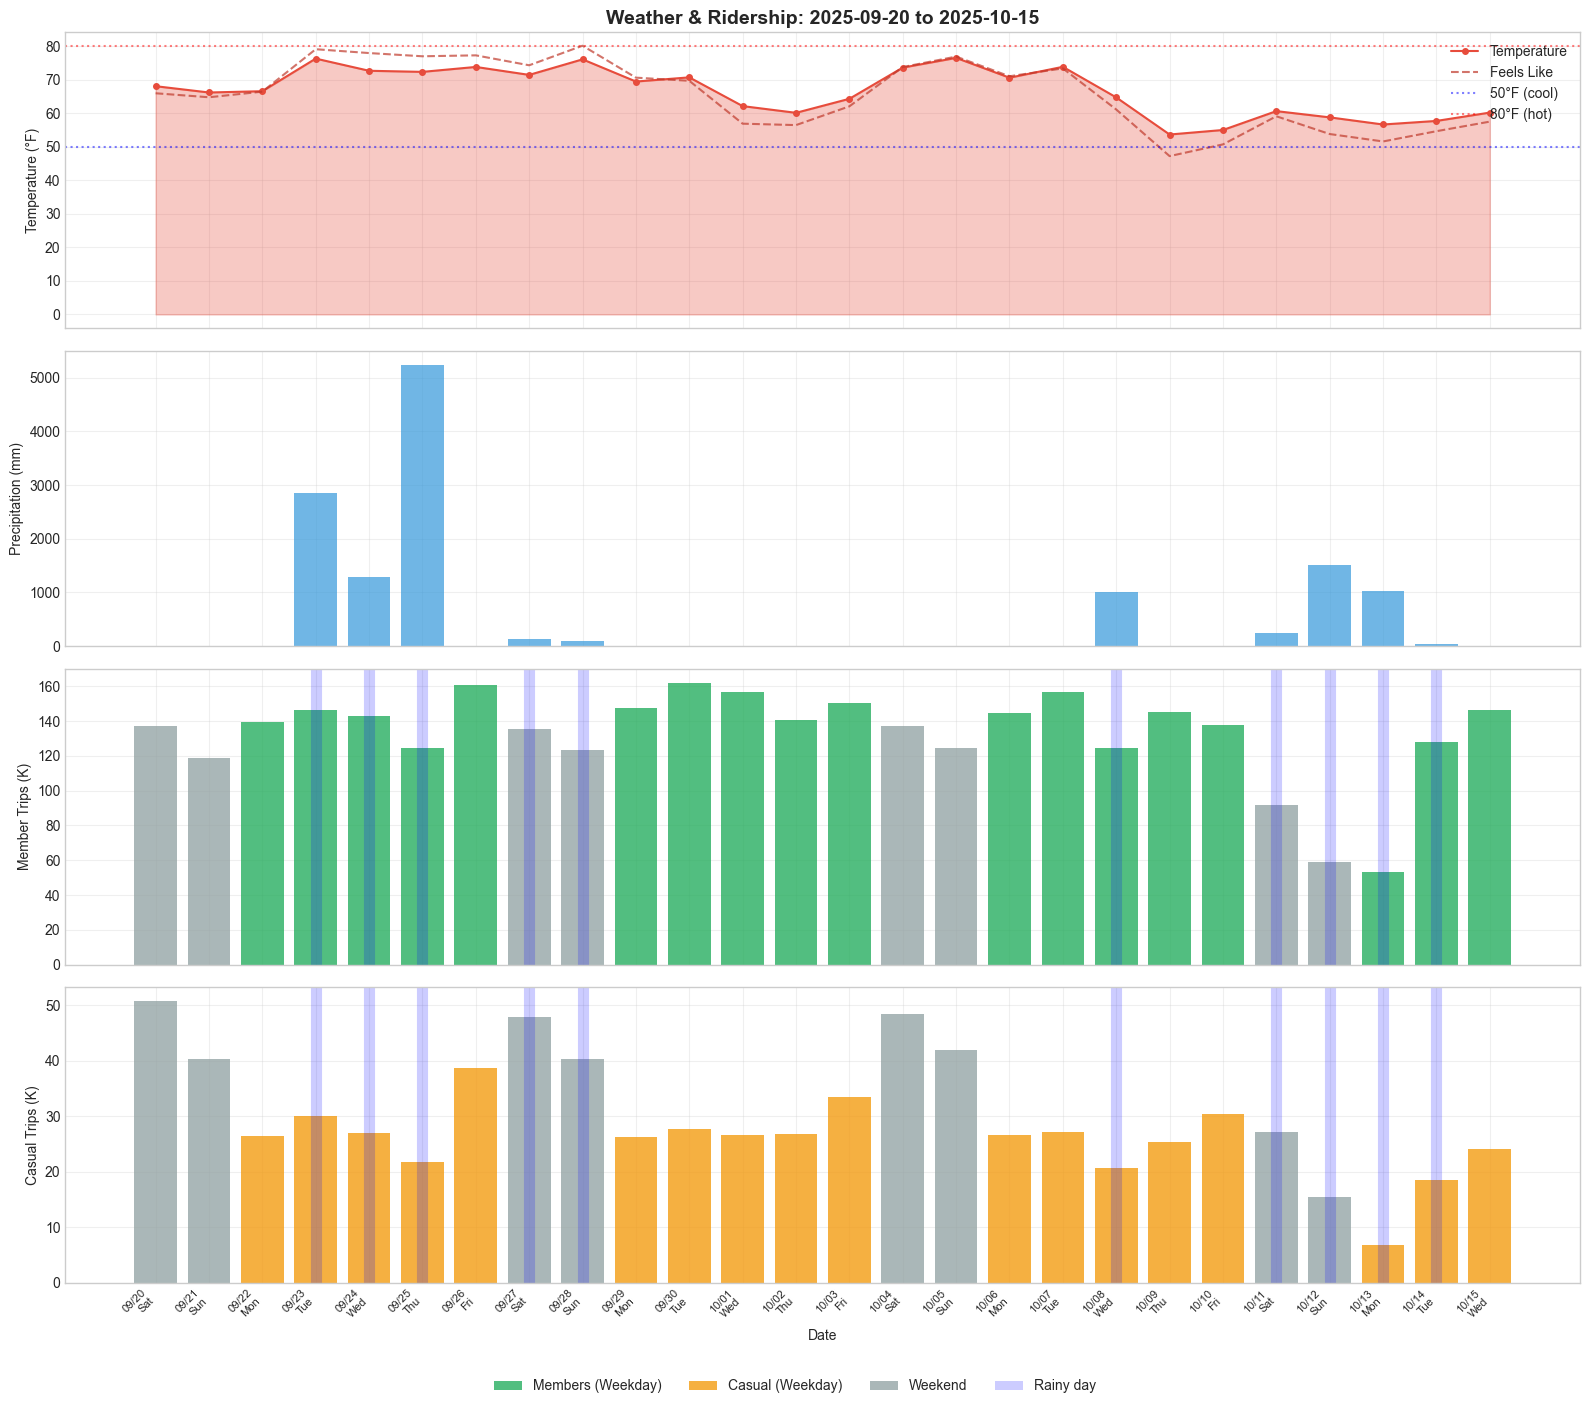

In [123]:
# Multi-panel visualization: Weather + Member + Casual trips
fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)

dates = explorer_data['date']
day_labels = explorer_data['day_name']

# Panel 1: Temperature
ax = axes[0]
ax.fill_between(dates, explorer_data['temp_f'], alpha=0.3, color='#e74c3c')
ax.plot(dates, explorer_data['temp_f'], 'o-', color='#e74c3c', markersize=4, label='Temperature')
ax.plot(dates, explorer_data['feels_like_f'], '--', color='#c0392b', alpha=0.7, label='Feels Like')
ax.axhline(50, color='blue', linestyle=':', alpha=0.5, label='50°F (cool)')
ax.axhline(80, color='red', linestyle=':', alpha=0.5, label='80°F (hot)')
ax.set_ylabel('Temperature (°F)')
ax.set_title(f'Weather & Ridership: {START_DATE} to {END_DATE}', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 2: Precipitation
ax = axes[1]
ax.bar(dates, explorer_data['avg_precip_mm'], color='#3498db', alpha=0.7, width=0.8)
ax.set_ylabel('Precipitation (mm)')
ax.grid(True, alpha=0.3)

# Panel 3: Member trips (the commuters)
ax = axes[2]
colors = ['#27ae60' if not w else '#95a5a6' for w in explorer_data['is_weekend']]
ax.bar(dates, explorer_data['member_trips']/1000, color=colors, alpha=0.8, width=0.8)
ax.set_ylabel('Member Trips (K)')
ax.grid(True, alpha=0.3)

# Highlight rainy days
for idx, row in explorer_data.iterrows():
    if row['is_rainy']:
        ax.axvline(row['date'], color='blue', alpha=0.2, linewidth=8)

# Panel 4: Casual trips (tourists/recreation)
ax = axes[3]
colors = ['#f39c12' if not w else '#95a5a6' for w in explorer_data['is_weekend']]
ax.bar(dates, explorer_data['casual_trips']/1000, color=colors, alpha=0.8, width=0.8)
ax.set_ylabel('Casual Trips (K)')
ax.set_xlabel('Date')
ax.grid(True, alpha=0.3)

# Highlight rainy days
for idx, row in explorer_data.iterrows():
    if row['is_rainy']:
        ax.axvline(row['date'], color='blue', alpha=0.2, linewidth=8)

# Add day of week labels for shorter periods
if len(explorer_data) <= 31:
    ax.set_xticks(dates)
    ax.set_xticklabels([f"{d.strftime('%m/%d')}\n{n}" for d, n in zip(dates, day_labels)], 
                       rotation=45, ha='right', fontsize=8)

# Add legend for the bar colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', alpha=0.8, label='Members (Weekday)'),
    Patch(facecolor='#f39c12', alpha=0.8, label='Casual (Weekday)'),
    Patch(facecolor='#95a5a6', alpha=0.8, label='Weekend'),
    Patch(facecolor='blue', alpha=0.2, label='Rainy day')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.savefig(f'../logs/daily_explorer_{START_DATE}_{END_DATE}.png', dpi=150, bbox_inches='tight')
plt.show()

In [124]:
# Correlation analysis: How do weather and ridership move together?
print("CORRELATION ANALYSIS")
print("="*50)
print(f"\nCorrelations with Temperature:")
print(f"  Member trips:  r = {explorer_data['member_trips'].corr(explorer_data['temp_f']):.3f}")
print(f"  Casual trips:  r = {explorer_data['casual_trips'].corr(explorer_data['temp_f']):.3f}")

print(f"\nCorrelations with Precipitation:")
print(f"  Member trips:  r = {explorer_data['member_trips'].corr(explorer_data['avg_precip_mm']):.3f}")
print(f"  Casual trips:  r = {explorer_data['casual_trips'].corr(explorer_data['avg_precip_mm']):.3f}")

print(f"\nMember-Casual correlation: r = {explorer_data['member_trips'].corr(explorer_data['casual_trips']):.3f}")

# Day-of-week summary table
print("\n" + "="*50)
print("DAILY BREAKDOWN")
print("="*50)
print(f"\n{'Date':<12} {'Day':<5} {'Temp':<7} {'Rain':<6} {'Members':<10} {'Casual':<10} {'Notes'}")
print("-"*75)

for _, row in explorer_data.iterrows():
    notes = []
    if row['is_weekend']:
        notes.append('Weekend')
    if row['is_rainy']:
        notes.append('Rainy')
    if row['holiday']:
        notes.append(row['holiday'])
    
    print(f"{row['date'].strftime('%Y-%m-%d'):<12} {row['day_name']:<5} {row['temp_f']:.0f}°F  "
          f"{row['avg_precip_mm']:.1f}mm  {row['member_trips']:>8,}  {row['casual_trips']:>8,}  "
          f"{', '.join(notes)}")

CORRELATION ANALYSIS

Correlations with Temperature:
  Member trips:  r = 0.372
  Casual trips:  r = 0.542

Correlations with Precipitation:
  Member trips:  r = -0.245
  Casual trips:  r = -0.320

Member-Casual correlation: r = 0.411

DAILY BREAKDOWN

Date         Day   Temp    Rain   Members    Casual     Notes
---------------------------------------------------------------------------
2025-09-20   Sat   68°F  0.0mm   136,987    50,705  Weekend
2025-09-21   Sun   66°F  0.0mm   118,822    40,315  Weekend
2025-09-22   Mon   67°F  0.0mm   139,220    26,429  
2025-09-23   Tue   76°F  2850.0mm   146,114    30,114  Rainy
2025-09-24   Wed   73°F  1284.7mm   142,888    27,011  Rainy
2025-09-25   Thu   72°F  5239.9mm   124,489    21,766  Rainy
2025-09-26   Fri   74°F  0.0mm   160,492    38,703  
2025-09-27   Sat   71°F  130.2mm   135,296    47,932  Weekend, Rainy
2025-09-28   Sun   76°F  92.8mm   123,275    40,379  Weekend, Rainy
2025-09-29   Mon   69°F  0.0mm   147,444    26,278  
2025-09-30

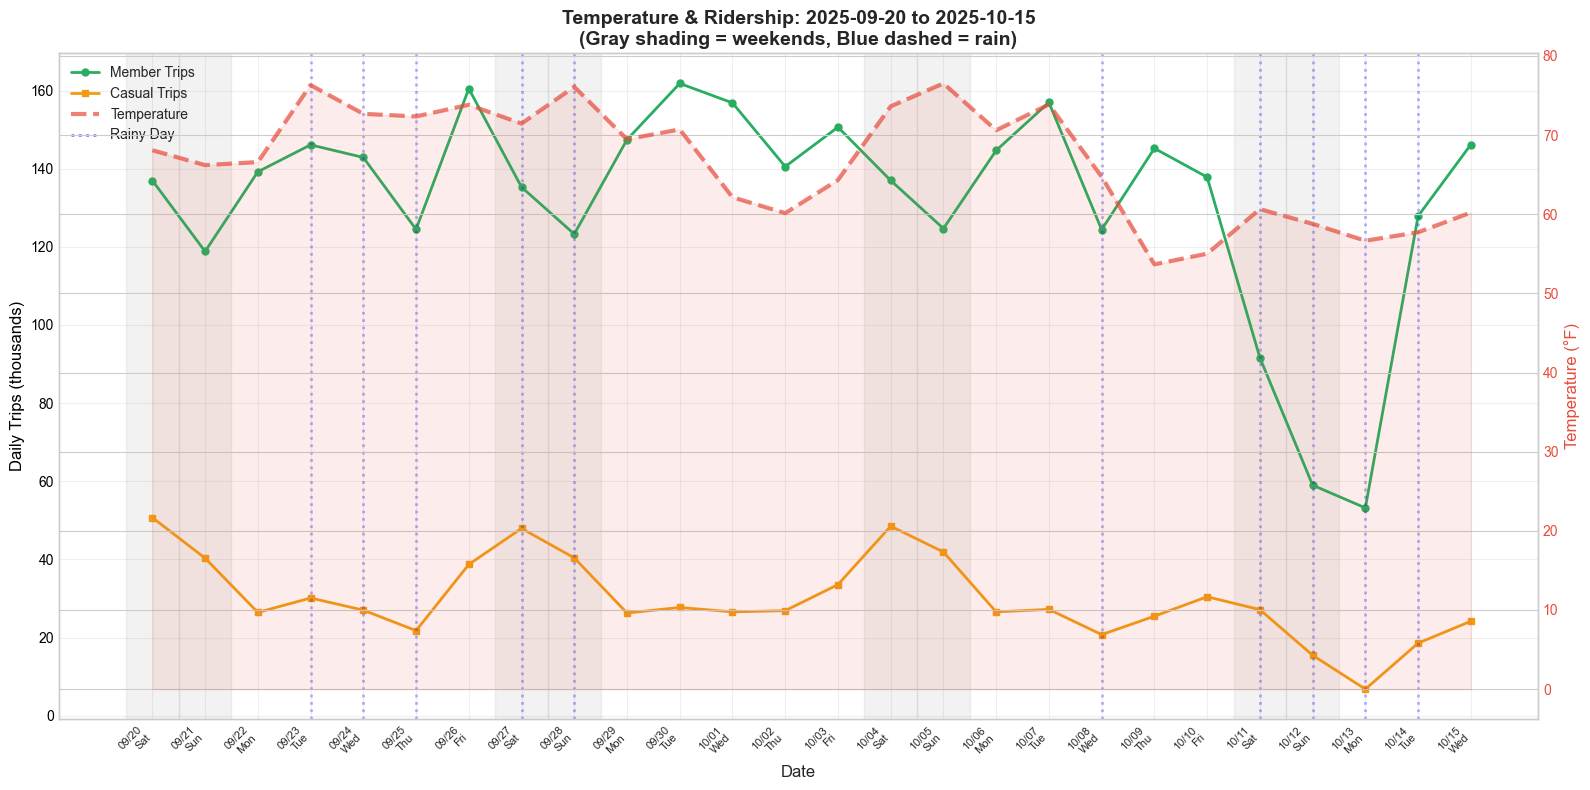


Correlation between temperature and trips:
  Temperature vs Member trips:  r = 0.372
  Temperature vs Casual trips:  r = 0.542


In [125]:
# Line graphs: Temperature and Rides overlaid
fig, ax1 = plt.subplots(figsize=(16, 8))

# Primary axis: Trips (lines)
ax1.plot(explorer_data['date'], explorer_data['member_trips']/1000, 
         'o-', linewidth=2, markersize=5, color='#27ae60', label='Member Trips')
ax1.plot(explorer_data['date'], explorer_data['casual_trips']/1000, 
         's-', linewidth=2, markersize=5, color='#f39c12', label='Casual Trips')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Daily Trips (thousands)', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# Secondary axis: Temperature
ax2 = ax1.twinx()
ax2.plot(explorer_data['date'], explorer_data['temp_f'], 
         '--', linewidth=3, color='#e74c3c', alpha=0.7, label='Temperature')
ax2.fill_between(explorer_data['date'], explorer_data['temp_f'], alpha=0.1, color='#e74c3c')
ax2.set_ylabel('Temperature (°F)', fontsize=12, color='#e74c3c')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

# Mark rainy days with vertical lines
for idx, row in explorer_data.iterrows():
    if row['is_rainy']:
        ax1.axvline(row['date'], color='blue', alpha=0.3, linewidth=2, linestyle=':')

# Add weekend shading
for idx, row in explorer_data.iterrows():
    if row['is_weekend']:
        ax1.axvspan(row['date'] - pd.Timedelta(hours=12), 
                   row['date'] + pd.Timedelta(hours=12), 
                   alpha=0.1, color='gray')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', linestyle=':', alpha=0.5, linewidth=2)]
ax1.legend(lines1 + lines2 + custom_lines, 
           labels1 + labels2 + ['Rainy Day'], 
           loc='upper left', fontsize=10)

# X-axis formatting
if len(explorer_data) <= 31:
    ax1.set_xticks(explorer_data['date'])
    ax1.set_xticklabels([f"{d.strftime('%m/%d')}\n{n}" for d, n in 
                         zip(explorer_data['date'], explorer_data['day_name'])], 
                        rotation=45, ha='right', fontsize=8)

plt.title(f'Temperature & Ridership: {START_DATE} to {END_DATE}\n(Gray shading = weekends, Blue dashed = rain)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../logs/temp_rides_line_{START_DATE}_{END_DATE}.png', dpi=150, bbox_inches='tight')
plt.show()

# Print correlation
print(f"\nCorrelation between temperature and trips:")
print(f"  Temperature vs Member trips:  r = {explorer_data['temp_f'].corr(explorer_data['member_trips']):.3f}")
print(f"  Temperature vs Casual trips:  r = {explorer_data['temp_f'].corr(explorer_data['casual_trips']):.3f}")

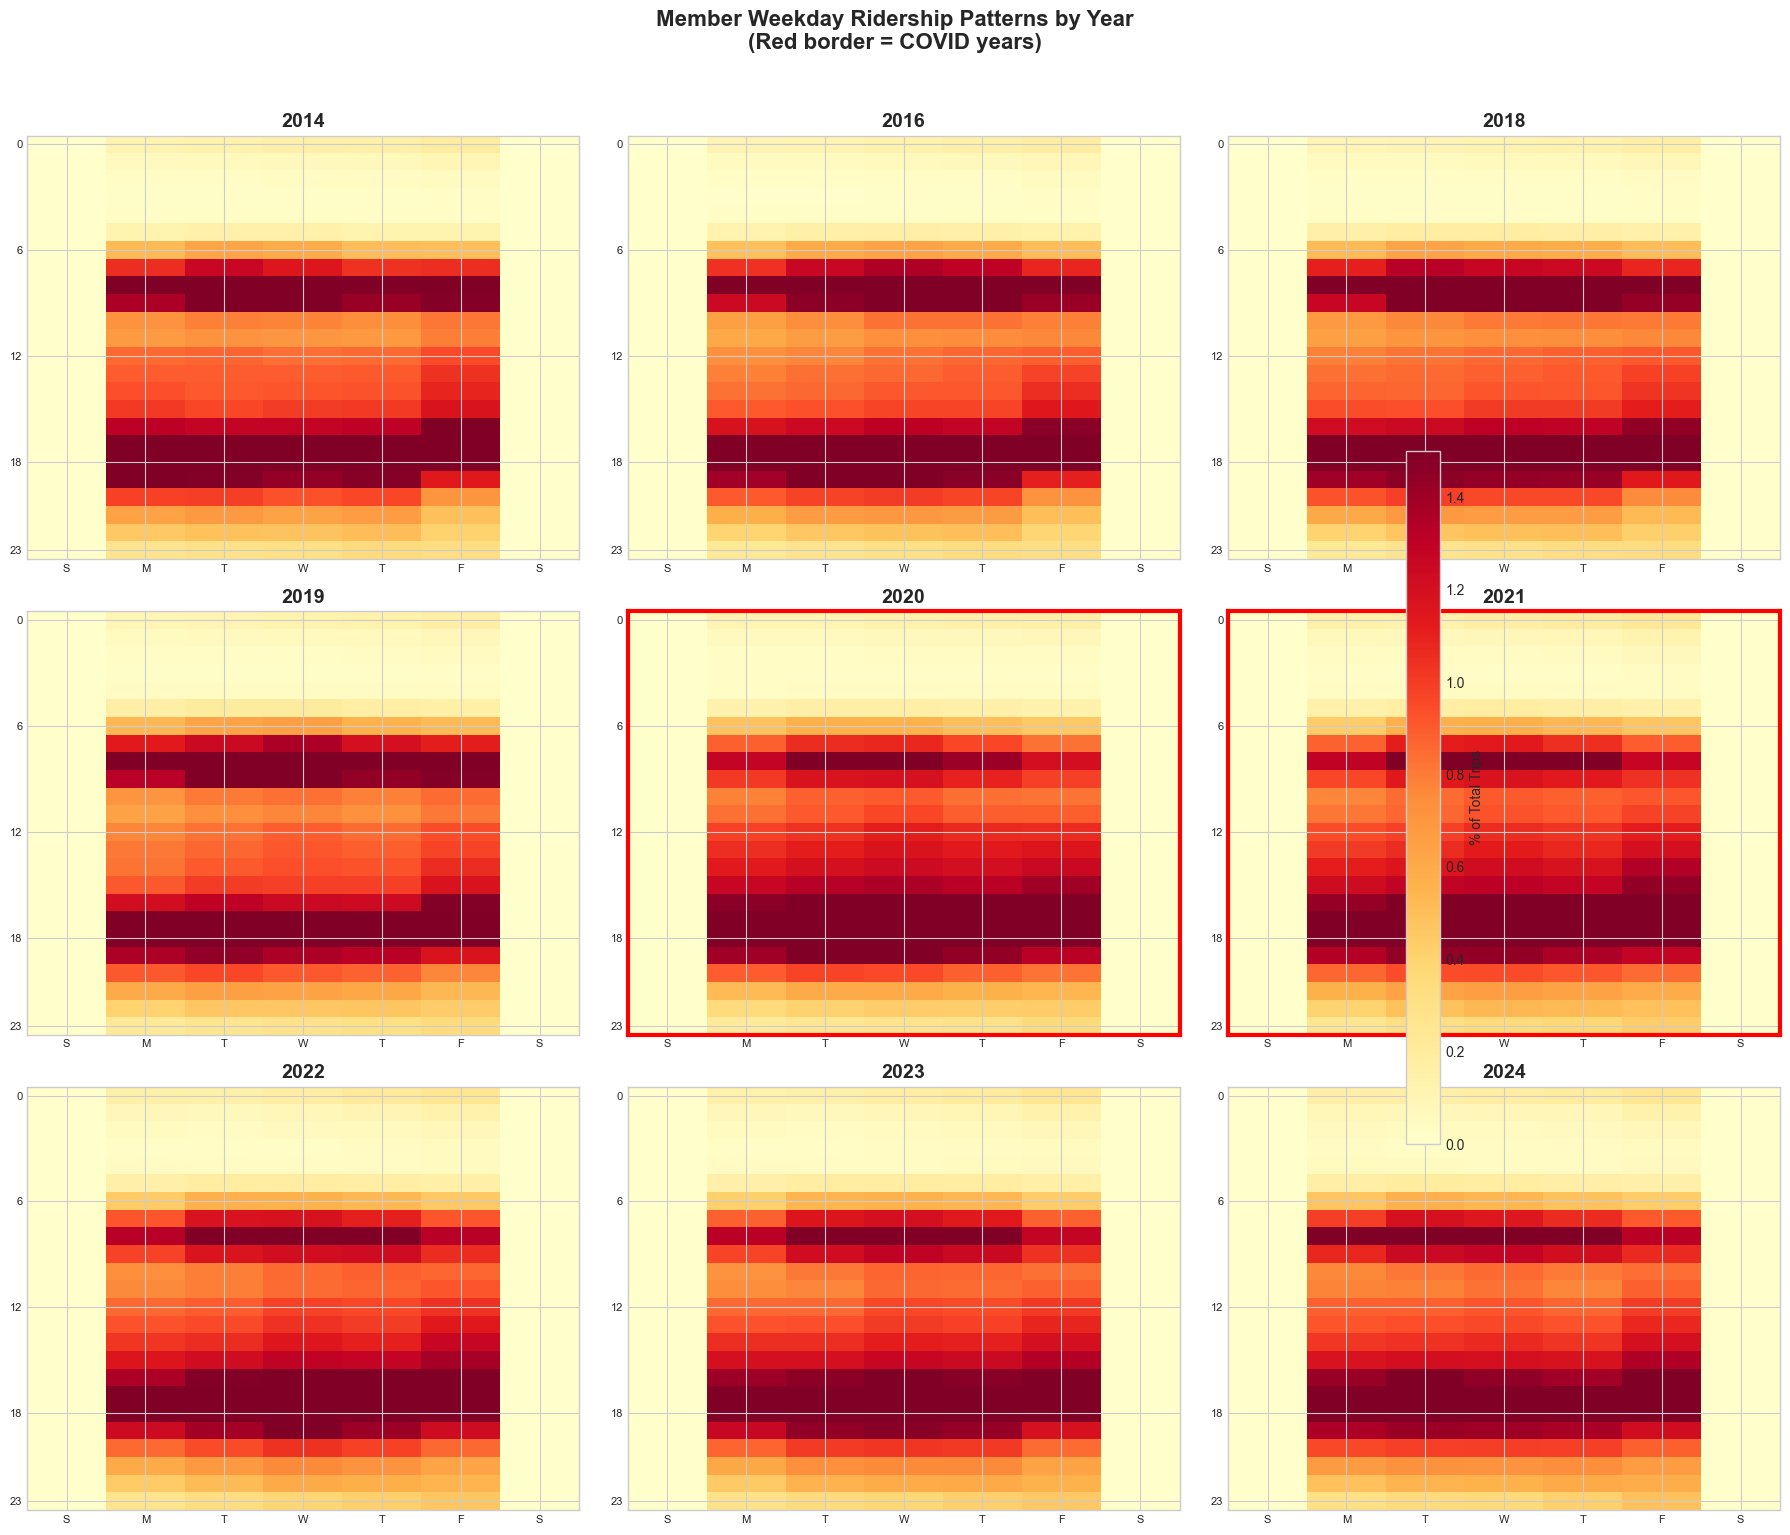

In [126]:
# Create small multiples heatmap grid
years_to_show = [2014, 2016, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

# Get member weekday heatmaps for comparison
for i, year in enumerate(years_to_show):
    ax = axes[i]
    
    subset = heatmap_data[
        (heatmap_data['year'] == year) &
        (heatmap_data['day_type'] == 'Weekday') &
        (heatmap_data['member_casual'] == 'member')
    ]
    
    if len(subset) > 0:
        pivot = subset.groupby(['hour', 'dow'])['trips'].sum().unstack(fill_value=0)
        pivot = pivot.reindex(index=range(24), columns=range(7), fill_value=0)
        
        # Normalize to percentages for fair comparison
        pivot_pct = pivot / pivot.sum().sum() * 100
        
        im = ax.imshow(pivot_pct.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1.5)
        ax.set_title(f'{int(year)}', fontsize=14, fontweight='bold')
        ax.set_xticks(range(7))
        ax.set_xticklabels(['S', 'M', 'T', 'W', 'T', 'F', 'S'], fontsize=8)
        ax.set_yticks([0, 6, 12, 18, 23])
        ax.set_yticklabels(['0', '6', '12', '18', '23'], fontsize=8)
        
        # Highlight COVID years
        if year in [2020, 2021]:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)

# Add colorbar
fig.colorbar(im, ax=axes, shrink=0.6, label='% of Total Trips')

fig.suptitle('Member Weekday Ridership Patterns by Year\n(Red border = COVID years)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../logs/heatmap_by_year.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Summary

In [127]:
print("="*70)
print("WORK FROM HOME ANALYSIS SUMMARY")
print("="*70)

# Get the key stats
pre_gap = yearly_pivot[yearly_pivot.index <= 2019]['WFH_gap'].mean()
post_gap = yearly_pivot[yearly_pivot.index >= 2022]['WFH_gap'].mean()

print(f"""
KEY FINDINGS:

1. WFH GAP (Tue-Wed-Thu vs Mon-Fri difference):
   - Pre-COVID (2014-2019): {pre_gap:.1f} percentage points
   - Post-COVID (2022-2025): {post_gap:.1f} percentage points
   - Change: {post_gap - pre_gap:+.1f} pp (larger gap = more WFH)

2. WEATHER-CONTROLLED REGRESSION:
   - Monday effect dropped by {model.params['monday_post_covid']:+,.0f} member trips/day post-COVID
   - Friday effect dropped by {model.params['friday_post_covid']:+,.0f} member trips/day post-COVID
   - These are ADDITIONAL drops beyond the normal Mon/Fri dip

3. GOOD WEATHER ANALYSIS:
   - {len(good_weather_days):,} good weather days (50-80°F, no rain, no holiday)
   - WFH pattern persists even on perfect biking days
   - This rules out "weather" as an alternative explanation

4. INTERPRETATION:
   - Clear evidence of increased WFH on Mondays and Fridays
   - The "3-day office week" (Tue-Wed-Thu) is visible in the data
   - Morning commute peak has shifted slightly later

INTERACTIVE FEATURES:
  - Section 8: Day-by-day explorer - change START_DATE/END_DATE to explore any period
  - logs/interactive_heatmap.html - toggle year/member/bike/day type

FILES CREATED:
  - logs/wfh_analysis.png
  - logs/wfh_regression.png
  - logs/wfh_good_weather.png
  - logs/hourly_shifts.png
  - logs/heatmap_by_year.png
  - logs/daily_explorer_*.png
""")

con.close()

WORK FROM HOME ANALYSIS SUMMARY

KEY FINDINGS:

1. WFH GAP (Tue-Wed-Thu vs Mon-Fri difference):
   - Pre-COVID (2014-2019): 5.2 percentage points
   - Post-COVID (2022-2025): 5.5 percentage points
   - Change: +0.3 pp (larger gap = more WFH)

2. WEATHER-CONTROLLED REGRESSION:
   - Monday effect dropped by -6,542 member trips/day post-COVID
   - Friday effect dropped by -3,067 member trips/day post-COVID
   - These are ADDITIONAL drops beyond the normal Mon/Fri dip

3. GOOD WEATHER ANALYSIS:
   - 1,158 good weather days (50-80°F, no rain, no holiday)
   - WFH pattern persists even on perfect biking days
   - This rules out "weather" as an alternative explanation

4. INTERPRETATION:
   - Clear evidence of increased WFH on Mondays and Fridays
   - The "3-day office week" (Tue-Wed-Thu) is visible in the data
   - Morning commute peak has shifted slightly later

INTERACTIVE FEATURES:
  - Section 8: Day-by-day explorer - change START_DATE/END_DATE to explore any period
  - logs/interactive_h